In [ ]:
import pandas as pd

df = pd.read_csv('DataSampled.csv')

# Convert 'datetime' column to actual datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek #0 to 6
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['day_name'] = df['datetime'].dt.day_name()

print("Data loaded successfully!")
print("   Shape:", df.shape)
print("   Date range:", df['datetime'].min(), "to", df['datetime'].max())
print("   Cities:", df['city'].unique())
print("   Applications:", df['app'].unique())
print("   Unique days:", len(df['date'].unique()))
print("   TILES:", len(df['tile_id'].unique()))

Data loaded successfully!
   Shape: (40000, 12)
   Date range: 2019-03-21 00:00:00 to 2019-03-24 23:00:00
   Cities: ['Lyon' 'Paris']
   Applications: ['Instagram' 'YouTube']
   Unique days: 4
   TILES: 1240


In [ ]:
df.head()

,datetime,tile_id,city,app,day,hour,traffic,time,date,day_of_week,is_weekend,day_name
0,2019-03-21 00:00:00,60163,Lyon,Instagram,20190321,0,110102,0:00,2019-03-21,3,0,Thursday
1,2019-03-21 03:00:00,71940,Lyon,Instagram,20190321,3,6625,3:00,2019-03-21,3,0,Thursday
2,2019-03-21 02:00:00,64491,Lyon,Instagram,20190321,2,7456,2:00,2019-03-21,3,0,Thursday
3,2019-03-21 00:00:00,75638,Lyon,Instagram,20190321,0,93423,0:00,2019-03-21,3,0,Thursday
4,2019-03-21 01:00:00,48340,Lyon,Instagram,20190321,1,17014,1:00,2019-03-21,3,0,Thursday


In [ ]:
print("Creating Separate DataFrames")
print("-" * 40)

# Create a dictionary to hold separate DataFrames
dataframes = {}

# Loop through each unique city and app combination
for city in df['city'].unique():
    for app in df['app'].unique():
        key = city.lower() + "_" + app.lower()
        subset = df[(df['city'] == city) & (df['app'] == app)].copy()

        if not subset.empty:
            dataframes[key] = subset.reset_index(drop=True)
            print(" Created", key + ":", len(subset), "records")
            print("   Date range:", subset['datetime'].min(), "to", subset['datetime'].max())


Creating Separate DataFrames
----------------------------------------
 Created lyon_instagram: 10000 records
   Date range: 2019-03-21 00:00:00 to 2019-03-24 23:00:00
 Created lyon_youtube: 10000 records
   Date range: 2019-03-21 00:00:00 to 2019-03-24 23:00:00
 Created paris_instagram: 10000 records
   Date range: 2019-03-21 00:00:00 to 2019-03-24 23:00:00
 Created paris_youtube: 10000 records
   Date range: 2019-03-21 00:00:00 to 2019-03-24 23:00:00


In [ ]:
print("Outlier Detection and Removal")
print("-" * 50)

cleaned_dataframes = {}
outlier_summary = {}

# Loop through each city-app dataset
for key, df in dataframes.items():
    print("\nProcessing", key + "...")

    original_count = len(df)

    # Calculate IQR (Interquartile Range)
    Q1 = df['traffic'].quantile(0.25)
    Q3 = df['traffic'].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    mask = (df['traffic'] >= lower_bound) & (df['traffic'] <= upper_bound)
    cleaned_df = df[mask].copy()

    # Calculate stats
    outliers_removed = original_count - len(cleaned_df)
    outlier_percentage = (outliers_removed / original_count) * 100

    # Save cleaned data
    cleaned_dataframes[key] = cleaned_df

    # Save summary info
    outlier_summary[key] = {
        'original_count': original_count,
        'cleaned_count': len(cleaned_df),
        'outliers_removed': outliers_removed,
        'outlier_percentage': outlier_percentage,
        'original_stats': {
            'mean': df['traffic'].mean(),
            'std': df['traffic'].std(),
            'min': df['traffic'].min(),
            'max': df['traffic'].max()
        },
        'cleaned_stats': {
            'mean': cleaned_df['traffic'].mean(),
            'std': cleaned_df['traffic'].std(),
            'min': cleaned_df['traffic'].min(),
            'max': cleaned_df['traffic'].max()
        }
    }

    # Print summary
    print("   Original:", original_count, "| Cleaned:", len(cleaned_df),
          "| Removed:", outliers_removed, "(", round(outlier_percentage, 2), "% )")
    print("   Original stats - Mean:", round(df['traffic'].mean(), 2),
          ", Max:", round(df['traffic'].max(), 2))
    print("   Cleaned stats - Mean:", round(cleaned_df['traffic'].mean(), 2),
          ", Max:", round(cleaned_df['traffic'].max(), 2))


Outlier Detection and Removal
--------------------------------------------------

Processing lyon_instagram...
   Original: 10000 | Cleaned: 8959 | Removed: 1041 ( 10.41 % )
   Original stats - Mean: 153799.57 , Max: 5719714
   Cleaned stats - Mean: 64839.93 , Max: 285392

Processing lyon_youtube...
   Original: 10000 | Cleaned: 8954 | Removed: 1046 ( 10.46 % )
   Original stats - Mean: 55568.25 , Max: 1764546
   Cleaned stats - Mean: 27291.59 , Max: 117720

Processing paris_instagram...
   Original: 10000 | Cleaned: 8791 | Removed: 1209 ( 12.09 % )
   Original stats - Mean: 720532.38 , Max: 19240525
   Cleaned stats - Mean: 343335.76 , Max: 1442144

Processing paris_youtube...
   Original: 10000 | Cleaned: 8959 | Removed: 1041 ( 10.41 % )
   Original stats - Mean: 281216.37 , Max: 5453971
   Cleaned stats - Mean: 158066.36 , Max: 655812


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

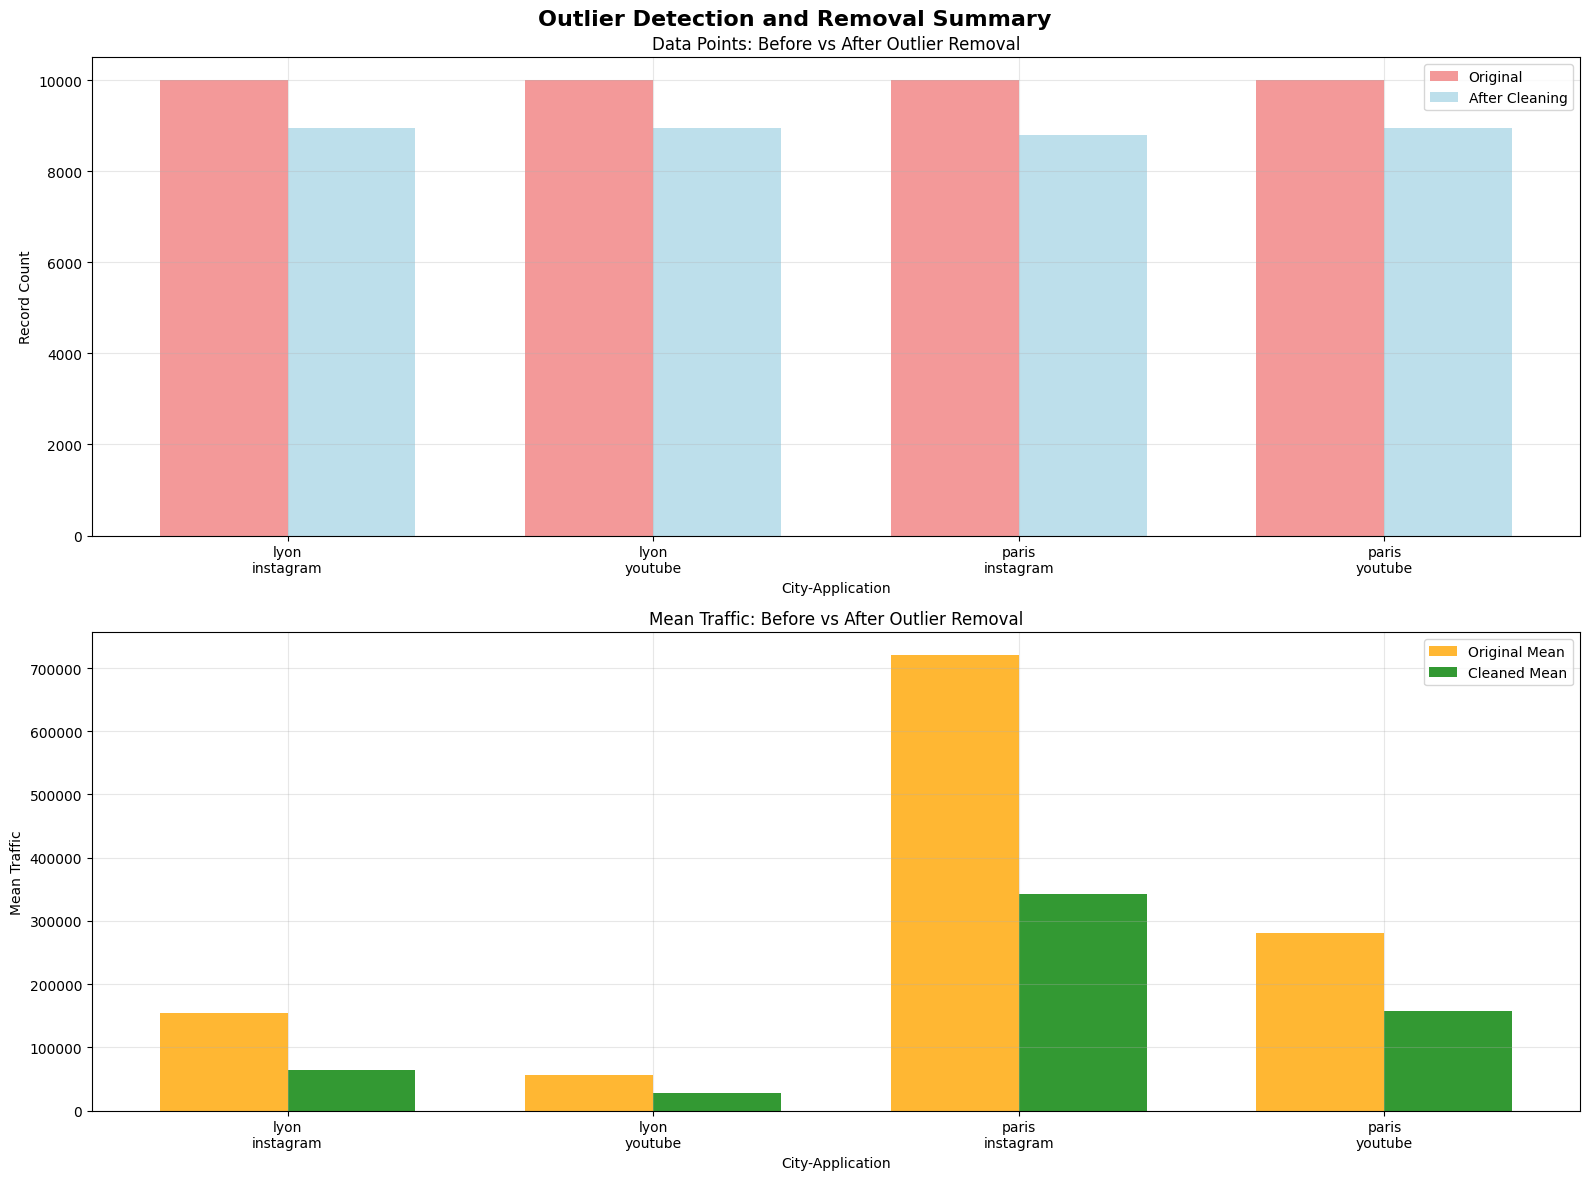

In [ ]:
# Set up plot style
plt.rcParams['figure.figsize'] = (15, 8)

# Set up the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Outlier Detection and Removal Summary', fontsize=16, fontweight='bold')

# List of city-app categories
categories = list(outlier_summary.keys())

# 1. Original vs Cleaned counts
original_counts = [outlier_summary[cat]['original_count'] for cat in categories]
cleaned_counts = [outlier_summary[cat]['cleaned_count'] for cat in categories]

x = np.arange(len(categories))
width = 0.35

axes[0].bar(x - width/2, original_counts, width, label='Original', color='lightcoral', alpha=0.8)
axes[0].bar(x + width/2, cleaned_counts, width, label='After Cleaning', color='lightblue', alpha=0.8)
axes[0].set_xlabel('City-Application')
axes[0].set_ylabel('Record Count')
axes[0].set_title('Data Points: Before vs After Outlier Removal')
axes[0].set_xticks(x)
axes[0].set_xticklabels([cat.replace('_', '\n') for cat in categories])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Outlier percentages
"""outlier_percentages = [outlier_summary[cat]['outlier_percentage'] for cat in categories]
axes[0, 1].bar(categories, outlier_percentages, color='red', alpha=0.7)
axes[0, 1].set_xlabel('City-Application')
axes[0, 1].set_ylabel('Outlier Percentage (%)')
axes[0, 1].set_title('Percentage of Outliers Removed')
axes[0, 1].set_xticklabels([cat.replace('_', '\n') for cat in categories])
axes[0, 1].grid(True, alpha=0.3)"""

# 3. Mean traffic before and after cleaning
original_means = [outlier_summary[cat]['original_stats']['mean'] for cat in categories]
cleaned_means = [outlier_summary[cat]['cleaned_stats']['mean'] for cat in categories]

axes[1].bar(x - width/2, original_means, width, label='Original Mean', color='orange', alpha=0.8)
axes[1].bar(x + width/2, cleaned_means, width, label='Cleaned Mean', color='green', alpha=0.8)
axes[1].set_xlabel('City-Application')
axes[1].set_ylabel('Mean Traffic')
axes[1].set_title('Mean Traffic: Before vs After Outlier Removal')
axes[1].set_xticks(x)
axes[1].set_xticklabels([cat.replace('_', '\n') for cat in categories])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 4. Boxplot of cleaned traffic data
"""traffic_data = [df['traffic'] for df in cleaned_dataframes.values()]
bp = axes[1, 1].boxplot(traffic_data, labels=[cat.replace('_', '\n') for cat in categories],
                        patch_artist=True, showfliers=False)

# Set box colors
colors = ['lightblue', 'lightgreen', 'orange', 'lightyellow']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes[1, 1].set_xlabel('City-Application')
axes[1, 1].set_ylabel('Traffic Volume')
axes[1, 1].set_title('Traffic Distribution by Category (After Cleaning)')
axes[1, 1].grid(True, alpha=0.3)"""

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


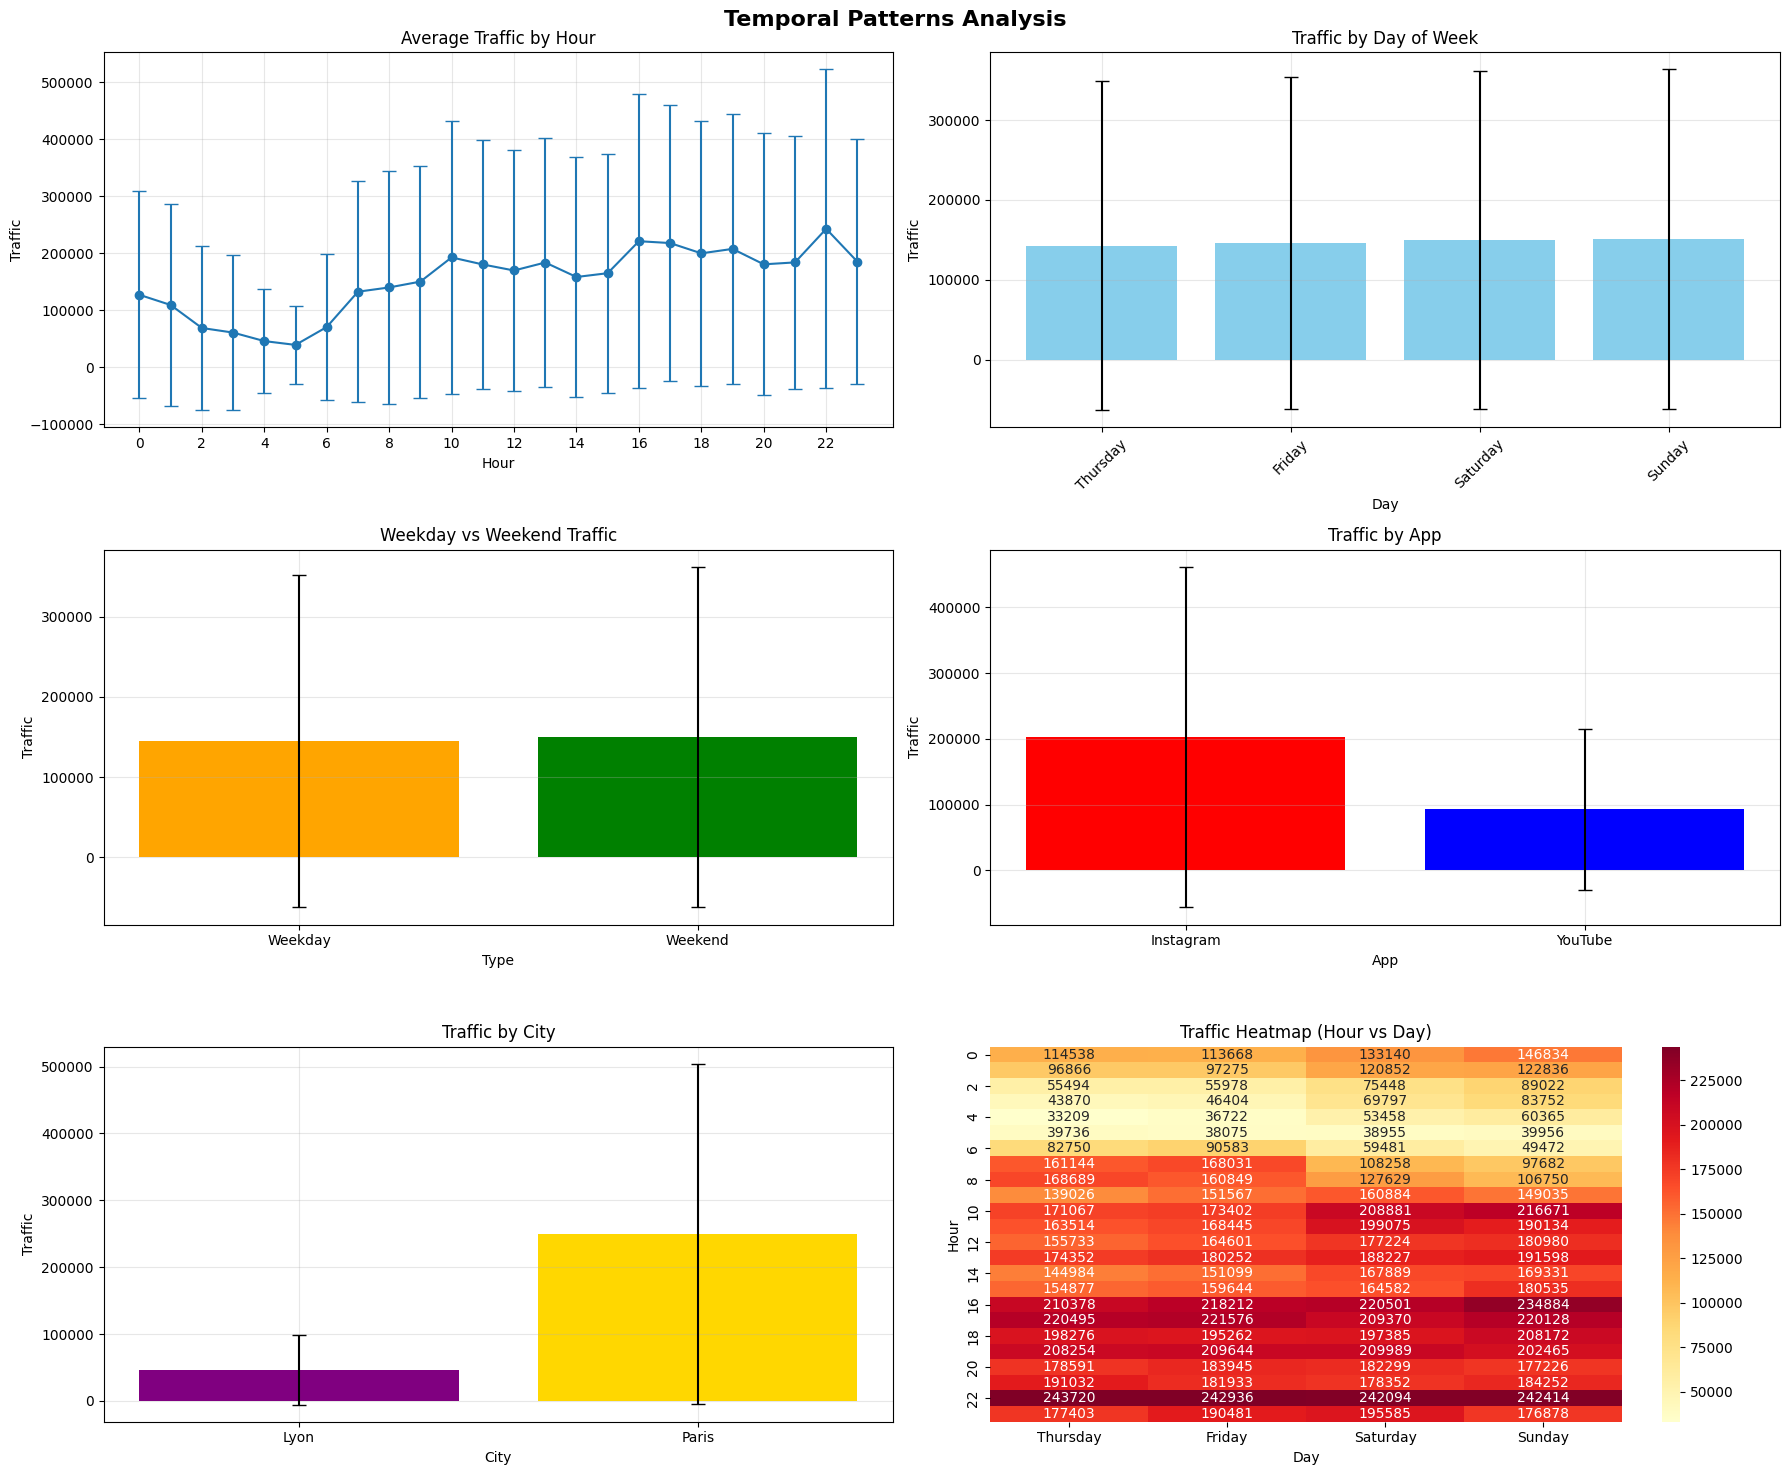

In [ ]:
# Combine all cleaned data
combined_df = pd.concat(cleaned_dataframes.values(), ignore_index=True)

# Set up figure and axes
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Temporal Patterns Analysis', fontsize=16, fontweight='bold')

# 1. Average traffic by hour
hourly = combined_df.groupby('hour')['traffic'].agg(['mean', 'std'])
axes[0, 0].errorbar(hourly.index, hourly['mean'], yerr=hourly['std'], marker='o', capsize=5)
axes[0, 0].set_title('Average Traffic by Hour')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Traffic')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# 2. Average traffic by day of the week
dow = combined_df.groupby('day_name')['traffic'].agg(['mean', 'std'])
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow = dow.reindex([d for d in order if d in dow.index])

axes[0, 1].bar(range(len(dow)), dow['mean'], yerr=dow['std'], color='skyblue', capsize=5)
axes[0, 1].set_title('Traffic by Day of Week')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Traffic')
axes[0, 1].set_xticks(range(len(dow)))
axes[0, 1].set_xticklabels(dow.index, rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Weekday vs Weekend
weekend = combined_df.groupby('is_weekend')['traffic'].agg(['mean', 'std'])
axes[1, 0].bar([0, 1], weekend['mean'], yerr=weekend['std'], color=['orange', 'green'], capsize=5)
axes[1, 0].set_title('Weekday vs Weekend Traffic')
axes[1, 0].set_xlabel('Type')
axes[1, 0].set_ylabel('Traffic')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Weekday', 'Weekend'])
axes[1, 0].grid(True, alpha=0.3)

# 4. Traffic by app
app = combined_df.groupby('app')['traffic'].agg(['mean', 'std'])
axes[1, 1].bar(app.index, app['mean'], yerr=app['std'], capsize=5, color=['red', 'blue'])
axes[1, 1].set_title('Traffic by App')
axes[1, 1].set_xlabel('App')
axes[1, 1].set_ylabel('Traffic')
axes[1, 1].grid(True, alpha=0.3)

# 5. Traffic by city
city = combined_df.groupby('city')['traffic'].agg(['mean', 'std'])
axes[2, 0].bar(city.index, city['mean'], yerr=city['std'], capsize=5, color=['purple', 'gold'])
axes[2, 0].set_title('Traffic by City')
axes[2, 0].set_xlabel('City')
axes[2, 0].set_ylabel('Traffic')
axes[2, 0].grid(True, alpha=0.3)

# 6. Heatmap: Hour vs Day
heatmap_data = combined_df.pivot_table(index='hour', columns='day_name', values='traffic', aggfunc='mean')
heatmap_data = heatmap_data[[d for d in order if d in heatmap_data.columns]]

sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', ax=axes[2, 1])
axes[2, 1].set_title('Traffic Heatmap (Hour vs Day)')
axes[2, 1].set_xlabel('Day')
axes[2, 1].set_ylabel('Hour')

plt.tight_layout()
plt.show()


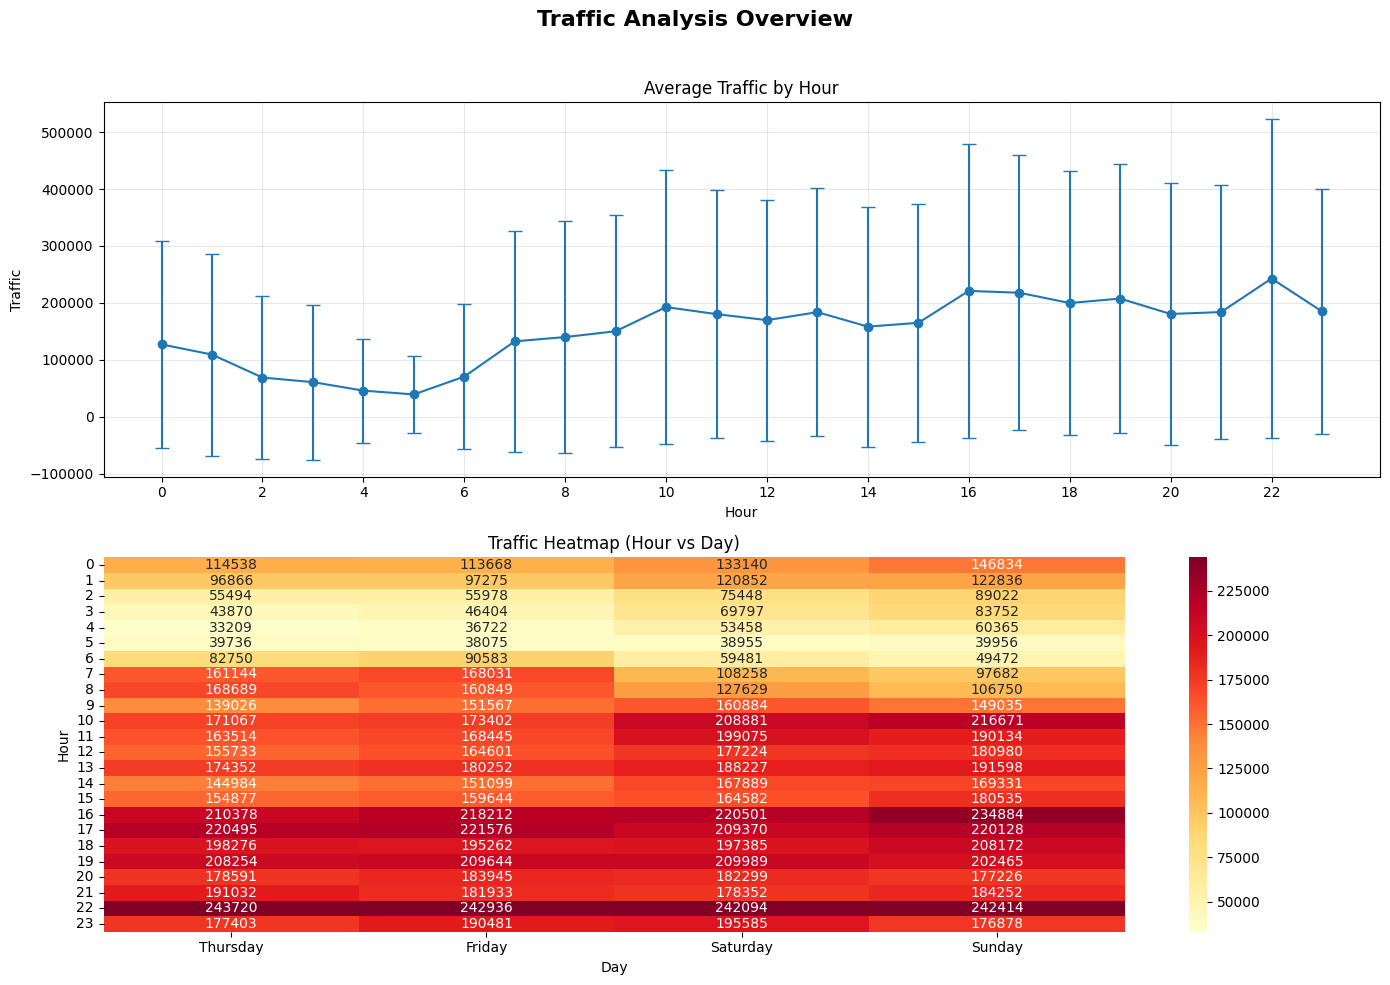

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all cleaned data
combined_df = pd.concat(cleaned_dataframes.values(), ignore_index=True)

# Set up 2x1 figure and axes
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Traffic Analysis Overview', fontsize=16, fontweight='bold')

# 1. Average traffic by hour
hourly = combined_df.groupby('hour')['traffic'].agg(['mean', 'std'])
axes[0].errorbar(hourly.index, hourly['mean'], yerr=hourly['std'], marker='o', capsize=5)
axes[0].set_title('Average Traffic by Hour')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Traffic')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# 2. Heatmap: Hour vs Day
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = combined_df.pivot_table(index='hour', columns='day_name', values='traffic', aggfunc='mean')
heatmap_data = heatmap_data[[d for d in order if d in heatmap_data.columns]]  # Reorder days

sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', ax=axes[1])
axes[1].set_title('Traffic Heatmap (Hour vs Day)')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Hour')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.show()


In [ ]:
# 3. Table: Traffic by Day of Week
dow = combined_df.groupby('day_name')['traffic'].agg(['mean', 'std'])
dow = dow.reindex([d for d in order if d in dow.index])
print("\nTraffic by Day of Week:")
print(dow.round(2))

# 4. Table: Weekday vs Weekend
weekend = combined_df.groupby('is_weekend')['traffic'].agg(['mean', 'std'])
weekend.index = weekend.index.map({0: 'Weekday', 1: 'Weekend'})
print("\nWeekday vs Weekend Traffic:")
print(weekend.round(2))

# 5. Table: Traffic by App
app = combined_df.groupby('app')['traffic'].agg(['mean', 'std'])
print("\nTraffic by App:")
print(app.round(2))

# 6. Table: Traffic by City
city = combined_df.groupby('city')['traffic'].agg(['mean', 'std'])
print("\nTraffic by City:")
print(city.round(2))


Traffic by Day of Week:
               mean        std
day_name                      
Thursday  142915.07  206165.83
Friday    145939.63  207885.38
Saturday  150004.26  211493.83
Sunday    150997.38  212451.34

Weekday vs Weekend Traffic:
                 mean        std
is_weekend                      
Weekday     144428.97  207028.00
Weekend     150500.16  211967.15

Traffic by App:
                mean        std
app                            
Instagram  202769.89  259048.28
YouTube     92697.23  122046.79

Traffic by City:
            mean        std
city                       
Lyon    46071.00   51745.01
Paris  249824.29  254299.75


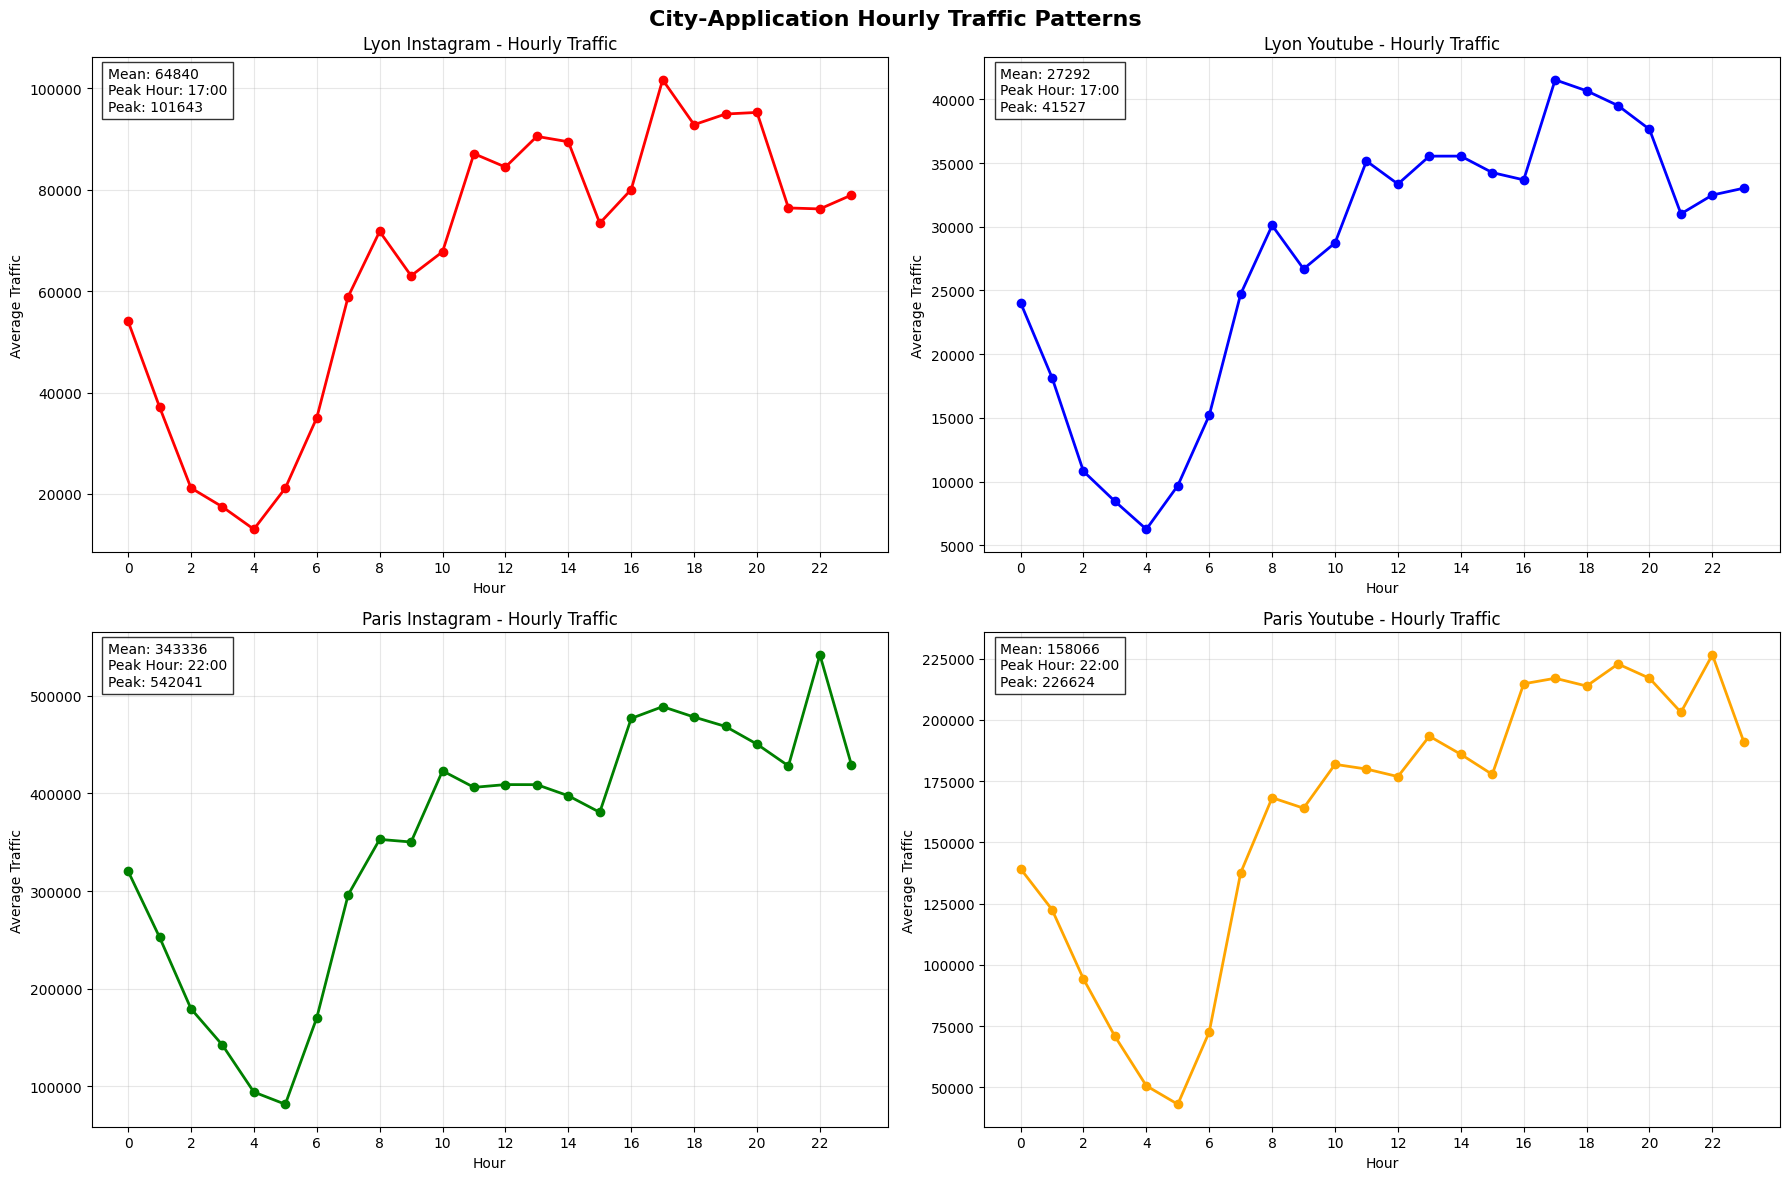

In [ ]:
# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('City-Application Hourly Traffic Patterns', fontsize=16, fontweight='bold')

# Define colors
colors = ['red', 'blue', 'green', 'orange']

# Plot each city-application combination (first 4)
for i, (key, df) in enumerate(cleaned_dataframes.items()):
    if i < 4:
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        # Average traffic by hour
        hourly = df.groupby('hour')['traffic'].mean()

        ax.plot(hourly.index, hourly.values, color=colors[i], linewidth=2, marker='o')
        ax.set_title(f'{key.replace("_", " ").title()} - Hourly Traffic')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Average Traffic')
        ax.set_xticks(range(0, 24, 2))
        ax.grid(True, alpha=0.3)

        # Stats text
        mean_val = df['traffic'].mean()
        peak_hour = hourly.idxmax()
        peak_val = hourly.max()
        text = f'Mean: {mean_val:.0f}\nPeak Hour: {peak_hour}:00\nPeak: {peak_val:.0f}'
        ax.text(0.02, 0.98, text, transform=ax.transAxes, verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


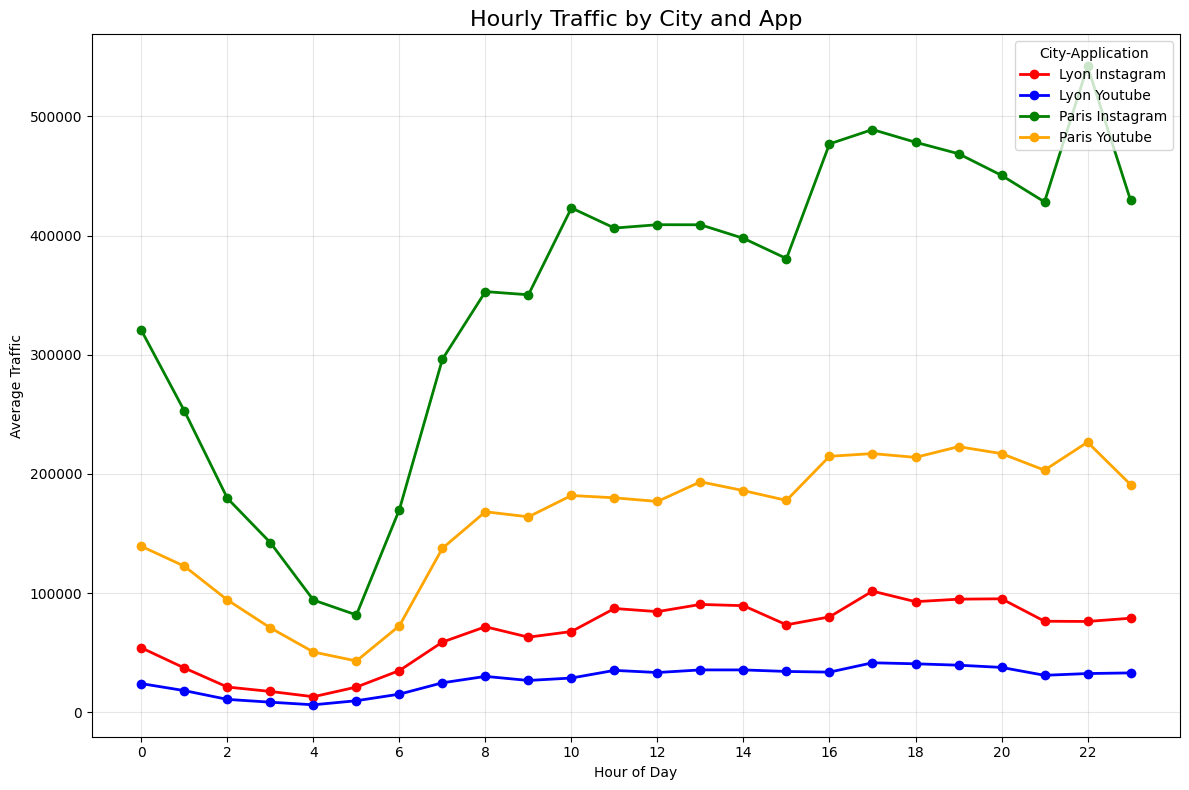

In [ ]:
# Create the figure
plt.figure(figsize=(12, 8))
plt.title('Hourly Traffic by City and App', fontsize=16)

# Define colors for each line
colors = ['red', 'blue', 'green', 'orange']

# Plot hourly patterns for each cleaned dataframe
for i, (key, df) in enumerate(cleaned_dataframes.items()):
    hourly_avg = df.groupby('hour')['traffic'].mean()
    label_name = key.replace('_', ' ').title()
    plt.plot(hourly_avg.index, hourly_avg.values, color=colors[i],
             linewidth=2, marker='o', label=label_name)

# Add labels and formatting
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)
plt.legend(title='City-Application', loc='upper right')
plt.tight_layout()
plt.show()


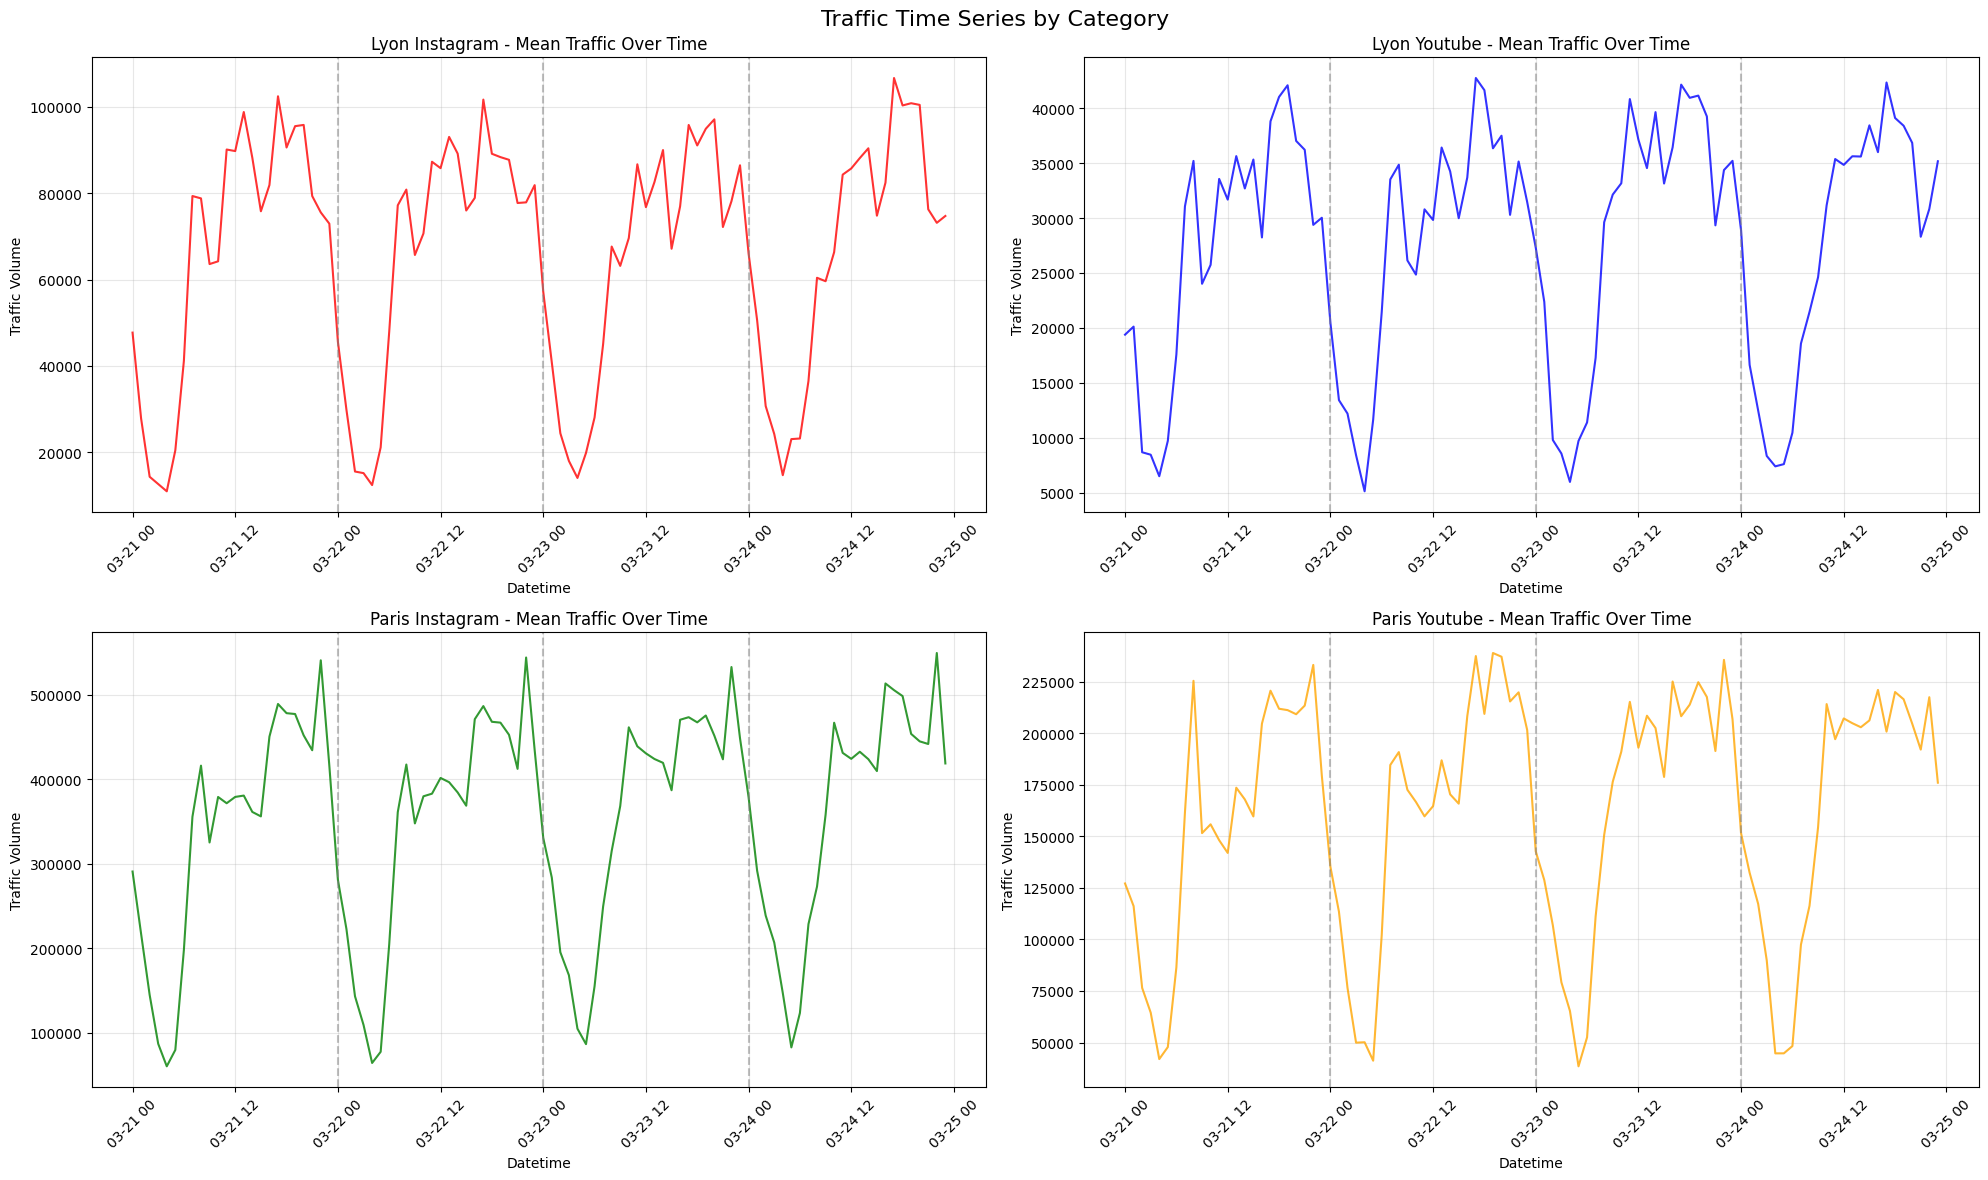

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Traffic Time Series by Category', fontsize=16)

colors = ['red', 'blue', 'green', 'orange']

for i, (key, df) in enumerate(cleaned_dataframes.items()):
    if i < 4:
        row = i // 2
        col = i % 2

        df_sorted = df.sort_values('datetime')

        # Group by datetime and get mean traffic for each timestamp
        max_traffic = df_sorted.groupby('datetime')['traffic'].mean().reset_index()

        # Plot the line connecting max traffic points
        axes[row, col].plot(max_traffic['datetime'], max_traffic['traffic'],
                            color=colors[i], linewidth=1.5, alpha=0.8)

        axes[row, col].set_title(key.replace("_", " ").title() + ' - Mean Traffic Over Time')
        axes[row, col].set_xlabel('Datetime')
        axes[row, col].set_ylabel('Traffic Volume')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].grid(True, alpha=0.3)

        # Add vertical lines at each new day
        for date in df_sorted['date'].unique()[1:]:
            day_line = pd.to_datetime(str(date) + " 00:00:00")
            axes[row, col].axvline(x=day_line, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


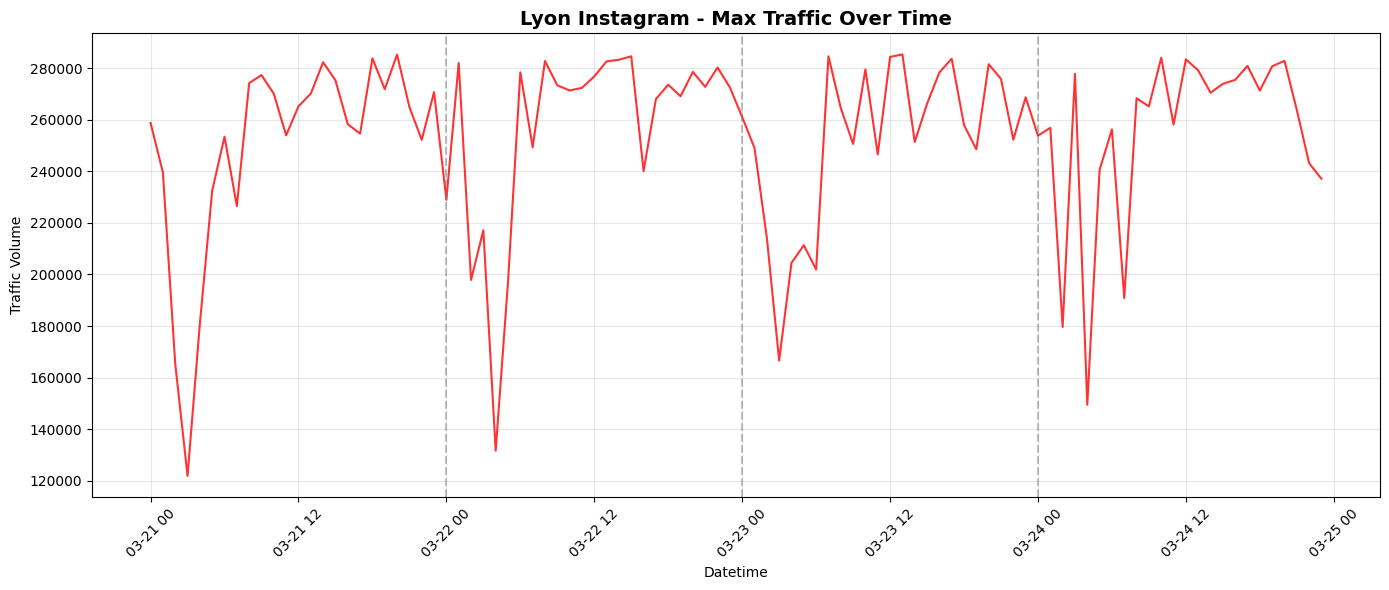

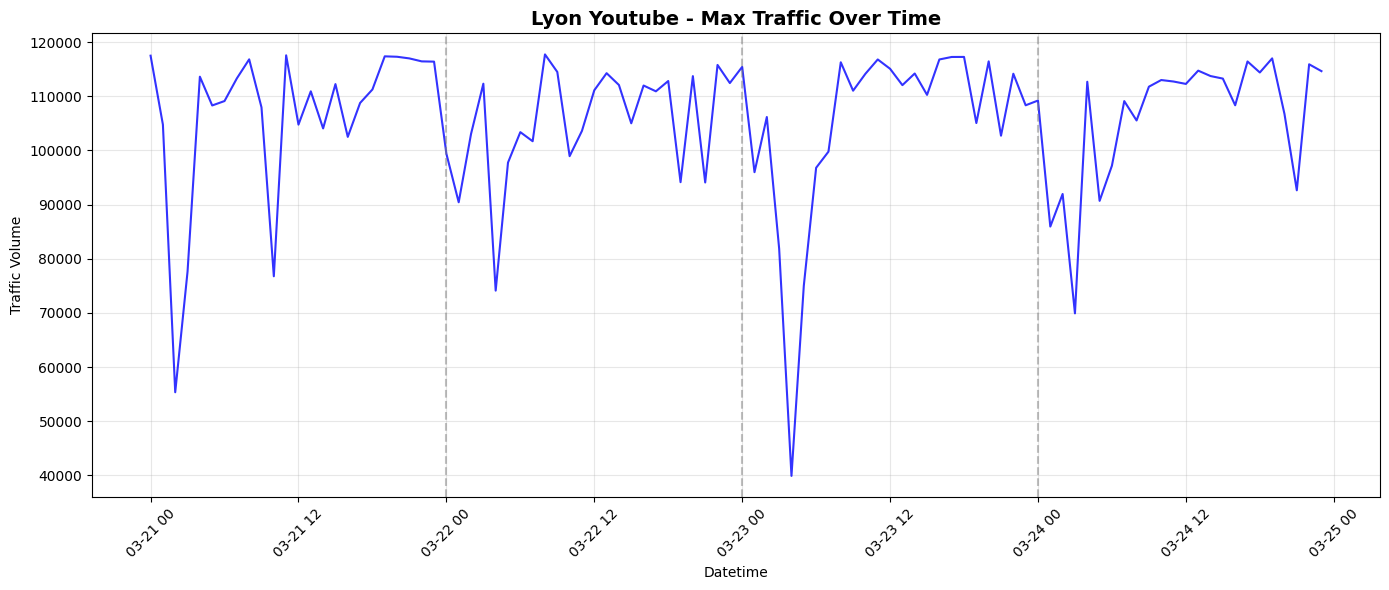

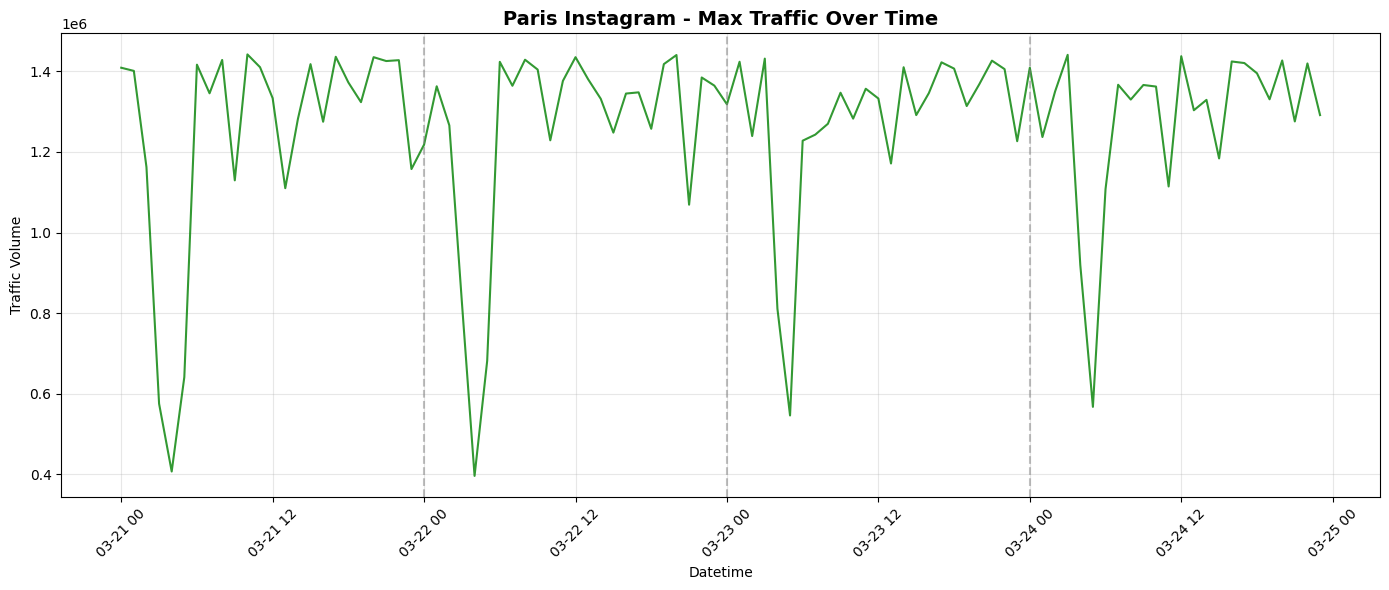

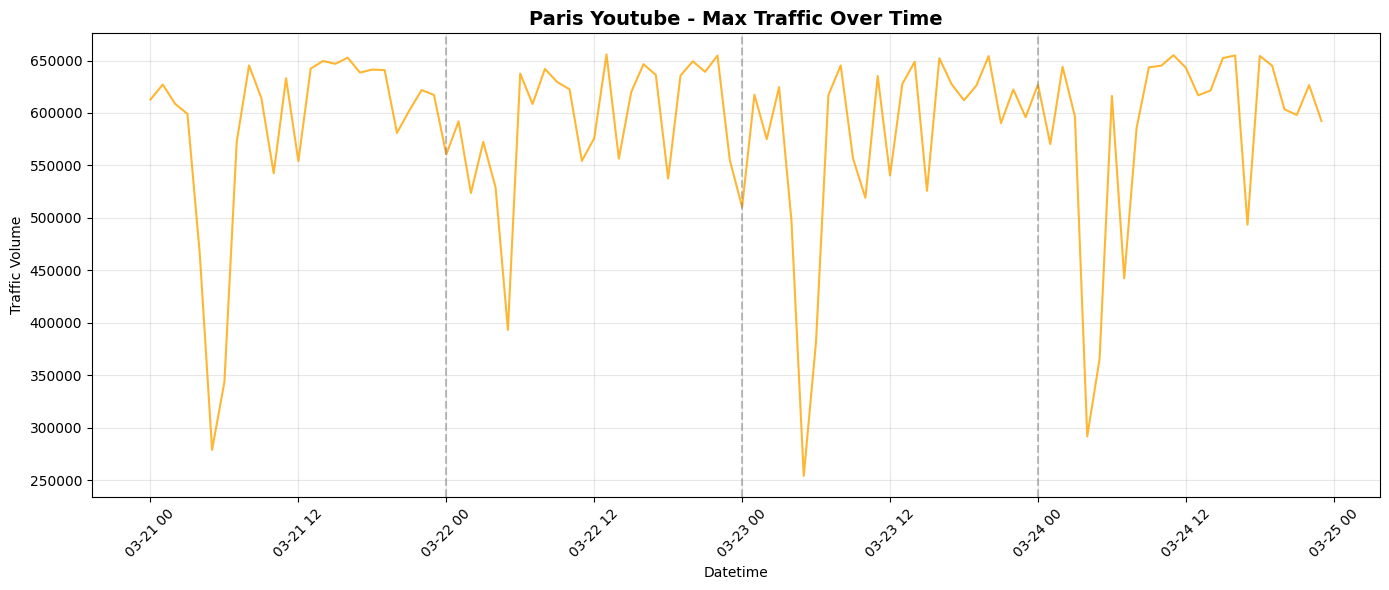

In [ ]:
colors = ['red', 'blue', 'green', 'orange']

# Loop through each city-application category
for i, (key, df) in enumerate(cleaned_dataframes.items()):
    # Sort the data by datetime
    df_sorted = df.sort_values('datetime')

    # Get max traffic per timestamp (to avoid vertical spikes)
    max_traffic = df_sorted.groupby('datetime')['traffic'].max().reset_index()

    # Create a new figure for each category
    plt.figure(figsize=(14, 6))

    # Plot the line connecting max traffic points
    plt.plot(max_traffic['datetime'], max_traffic['traffic'],
             color=colors[i], linewidth=1.5, alpha=0.8)

    # Add title and axis labels
    title = key.replace("_", " ").title() + " - Max Traffic Over Time"
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Datetime')
    plt.ylabel('Traffic Volume')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add grid to the plot
    plt.grid(True, alpha=0.3)

    # Add vertical dashed lines at the start of each new day
    unique_dates = df_sorted['date'].unique()
    for date in unique_dates[1:]:  # Skip the first day
        date_boundary = pd.to_datetime(str(date) + " 00:00:00")
        plt.axvline(x=date_boundary, color='gray', linestyle='--', alpha=0.5)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
# Create an empty table to store results
summary_table = pd.DataFrame()

# Loop through each cleaned dataset
for category, data in cleaned_dataframes.items():
    # Calculate basic statistics for 'traffic'
    count = len(data)
    mean = data['traffic'].mean()
    median = data['traffic'].median()
    std = data['traffic'].std()
    minimum = data['traffic'].min()
    maximum = data['traffic'].max()
    q1 = data['traffic'].quantile(0.25)
    q3 = data['traffic'].quantile(0.75)
    skew = data['traffic'].skew()
    kurt = data['traffic'].kurtosis()

    # Find peak and low traffic hours
    avg_by_hour = data.groupby('hour')['traffic'].mean()
    peak_hour = avg_by_hour.idxmax()
    low_hour = avg_by_hour.idxmin()

    # Create a dictionary for the summary
    row = {
        'Category': category.replace('_', ' ').title(),
        'Count': count,
        'Mean': mean,
        'Median': median,
        'Std': std,
        'Min': minimum,
        'Max': maximum,
        'Q1': q1,
        'Q3': q3,
        'Skewness': skew,
        'Kurtosis': kurt,
        'Peak_Hour': peak_hour,
        'Low_Hour': low_hour
    }

    # Add to the summary table
    summary_table = pd.concat([summary_table, pd.DataFrame([row])], ignore_index=True)

# Print the result
print("\n📊 Statistical Summary by Category:")
print("="*80)
print(summary_table.round(2).to_string(index=False))



📊 Statistical Summary by Category:
       Category  Count      Mean   Median       Std  Min     Max       Q1        Q3  Skewness  Kurtosis  Peak_Hour  Low_Hour
 Lyon Instagram   8959  64839.93  44029.0  62944.64    4  285392  17853.0  91912.00      1.36      1.25         17         4
   Lyon Youtube   8954  27291.59  18626.5  26218.91    2  117720   7725.0  38396.25      1.37      1.30         17         4
Paris Instagram   8791 343335.76 260999.0 303830.56  899 1442144 105890.0 486712.00      1.30      1.38         22         5
  Paris Youtube   8959 158066.36 113520.0 143344.17  133  655812  46852.5 225576.50      1.27      1.08         22         5


In [ ]:

print("\n🔧 Step 5: Feature Engineering for Predictive Modeling")
print("-" * 50)

enhanced_dataframes = {}

for key, df in cleaned_dataframes.items():
    print(f"Engineering features for {key}...")

    # Sort by datetime
    df = df.sort_values('datetime').reset_index(drop=True)

    # Traffic growth rate
    df['traffic_growth'] = df['traffic'].pct_change()
    df['traffic_growth_2'] = df['traffic'].pct_change(periods=2)

    # Time-based features
    df['hour_group'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    df['hour_group_encoded'] = df['hour_group'].cat.codes

    # Statistical features within each hour across days
    hourly_stats = df.groupby('hour')['traffic'].agg(['mean', 'std']).reset_index()
    hourly_stats.columns = ['hour', 'hourly_mean', 'hourly_std']
    df = df.merge(hourly_stats, on='hour', how='left')

    # Deviation from hourly average
    df['traffic_deviation'] = df['traffic'] - df['hourly_mean']
    df['traffic_normalized'] = df['traffic_deviation'] / (df['hourly_std'] + 1e-8)

    enhanced_dataframes[key] = df
    print(f"   Features created: {df.shape[1]} columns")



🔧 Step 5: Feature Engineering for Predictive Modeling
--------------------------------------------------
Engineering features for lyon_instagram...
   Features created: 20 columns
Engineering features for lyon_youtube...
   Features created: 20 columns
Engineering features for paris_instagram...
   Features created: 20 columns
Engineering features for paris_youtube...
   Features created: 20 columns


In [ ]:
enhanced_dataframes['lyon_youtube'].head()

,datetime,tile_id,city,app,day,hour,traffic,time,date,day_of_week,...,is_peak_morning,is_peak_evening,is_late_night,is_midday,hour_group,hour_group_encoded,hourly_mean,hourly_std,traffic_deviation,traffic_normalized
0,2019-03-21,60163,Lyon,YouTube,20190321,0,23168,0:00,2019-03-21,3,...,0,0,1,0,NaN,-1,24043.428571,25927.478232,-875.428571,-0.033765
1,2019-03-21,68362,Lyon,YouTube,20190321,0,24979,0:00,2019-03-21,3,...,0,0,1,0,NaN,-1,24043.428571,25927.478232,935.571429,0.036084
2,2019-03-21,47304,Lyon,YouTube,20190321,0,6550,0:00,2019-03-21,3,...,0,0,1,0,NaN,-1,24043.428571,25927.478232,-17493.428571,-0.674706
3,2019-03-21,57622,Lyon,YouTube,20190321,0,9215,0:00,2019-03-21,3,...,0,0,1,0,NaN,-1,24043.428571,25927.478232,-14828.428571,-0.571919
4,2019-03-21,64615,Lyon,YouTube,20190321,0,6438,0:00,2019-03-21,3,...,0,0,1,0,NaN,-1,24043.428571,25927.478232,-17605.428571,-0.679026


In [ ]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
print("\n🤖 Step 6: Building Predictive Models")
print("-" * 40)

model_results = {}
feature_importance_data = {}

# Define feature columns (optimized for small dataset)
feature_cols = ['hour', 'day_of_week', 'is_weekend', 'traffic_growth', 'hour_group_encoded', 'hourly_mean', 'traffic_deviation']

for key, df in enhanced_dataframes.items():
    print(f"\nBuilding models for {key}...")

    # Prepare data
    df_clean = df.dropna()

    X = df_clean[feature_cols]
    y = df_clean['traffic']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models (optimized for small dataset)
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=50, max_depth=3, random_state=42),
    }

    category_results = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Training metrics
        mae_train = mean_absolute_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_train = r2_score(y_train, y_train_pred)

        # MAPE (avoid division by zero)
        mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1))) * 100

        category_results[model_name] = {
            'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape,
            'MAE_train': mae_train, 'RMSE_train': rmse_train, 'R2_train': r2_train,
            'y_test': y_test, 'y_pred': y_pred, 'y_train': y_train, 'y_train_pred': y_train_pred,
            'model': model, 'scaler': scaler if model_name == 'Linear Regression' else None
        }

        # Feature importance for tree-based models
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            if key not in feature_importance_data:
                feature_importance_data[key] = {}
            feature_importance_data[key][model_name] = importance_df

        print(f"   {model_name}:")
        print(f"     Test:  MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}, MAPE={mape:.2f}%")
        print(f"     Train: MAE={mae_train:.2f}, RMSE={rmse_train:.2f}, R²={r2_train:.3f}")


    model_results[key] = category_results


🤖 Step 6: Building Predictive Models
----------------------------------------

Building models for lyon_instagram...
   Random Forest:
     Test:  MAE=5724.53, RMSE=7375.91, R²=0.986, MAPE=63.68%
     Train: MAE=5586.31, RMSE=7266.59, R²=0.987
   Gradient Boosting:
     Test:  MAE=2870.58, RMSE=3855.63, R²=0.996, MAPE=44.08%
     Train: MAE=2619.75, RMSE=3488.90, R²=0.997
   XGBoost:
     Test:  MAE=2072.42, RMSE=2889.09, R²=0.998, MAPE=12.80%
     Train: MAE=2018.47, RMSE=2842.51, R²=0.998

Building models for lyon_youtube...
   Random Forest:
     Test:  MAE=2556.92, RMSE=3316.22, R²=0.984, MAPE=63.39%
     Train: MAE=2499.71, RMSE=3245.38, R²=0.985
   Gradient Boosting:
     Test:  MAE=1102.98, RMSE=1485.31, R²=0.997, MAPE=42.68%
     Train: MAE=1070.18, RMSE=1413.98, R²=0.997
   XGBoost:
     Test:  MAE=797.70, RMSE=1113.97, R²=0.998, MAPE=14.04%
     Train: MAE=753.03, RMSE=1042.59, R²=0.998

Building models for paris_instagram...
   Random Forest:
     Test:  MAE=30978.58, RMSE=

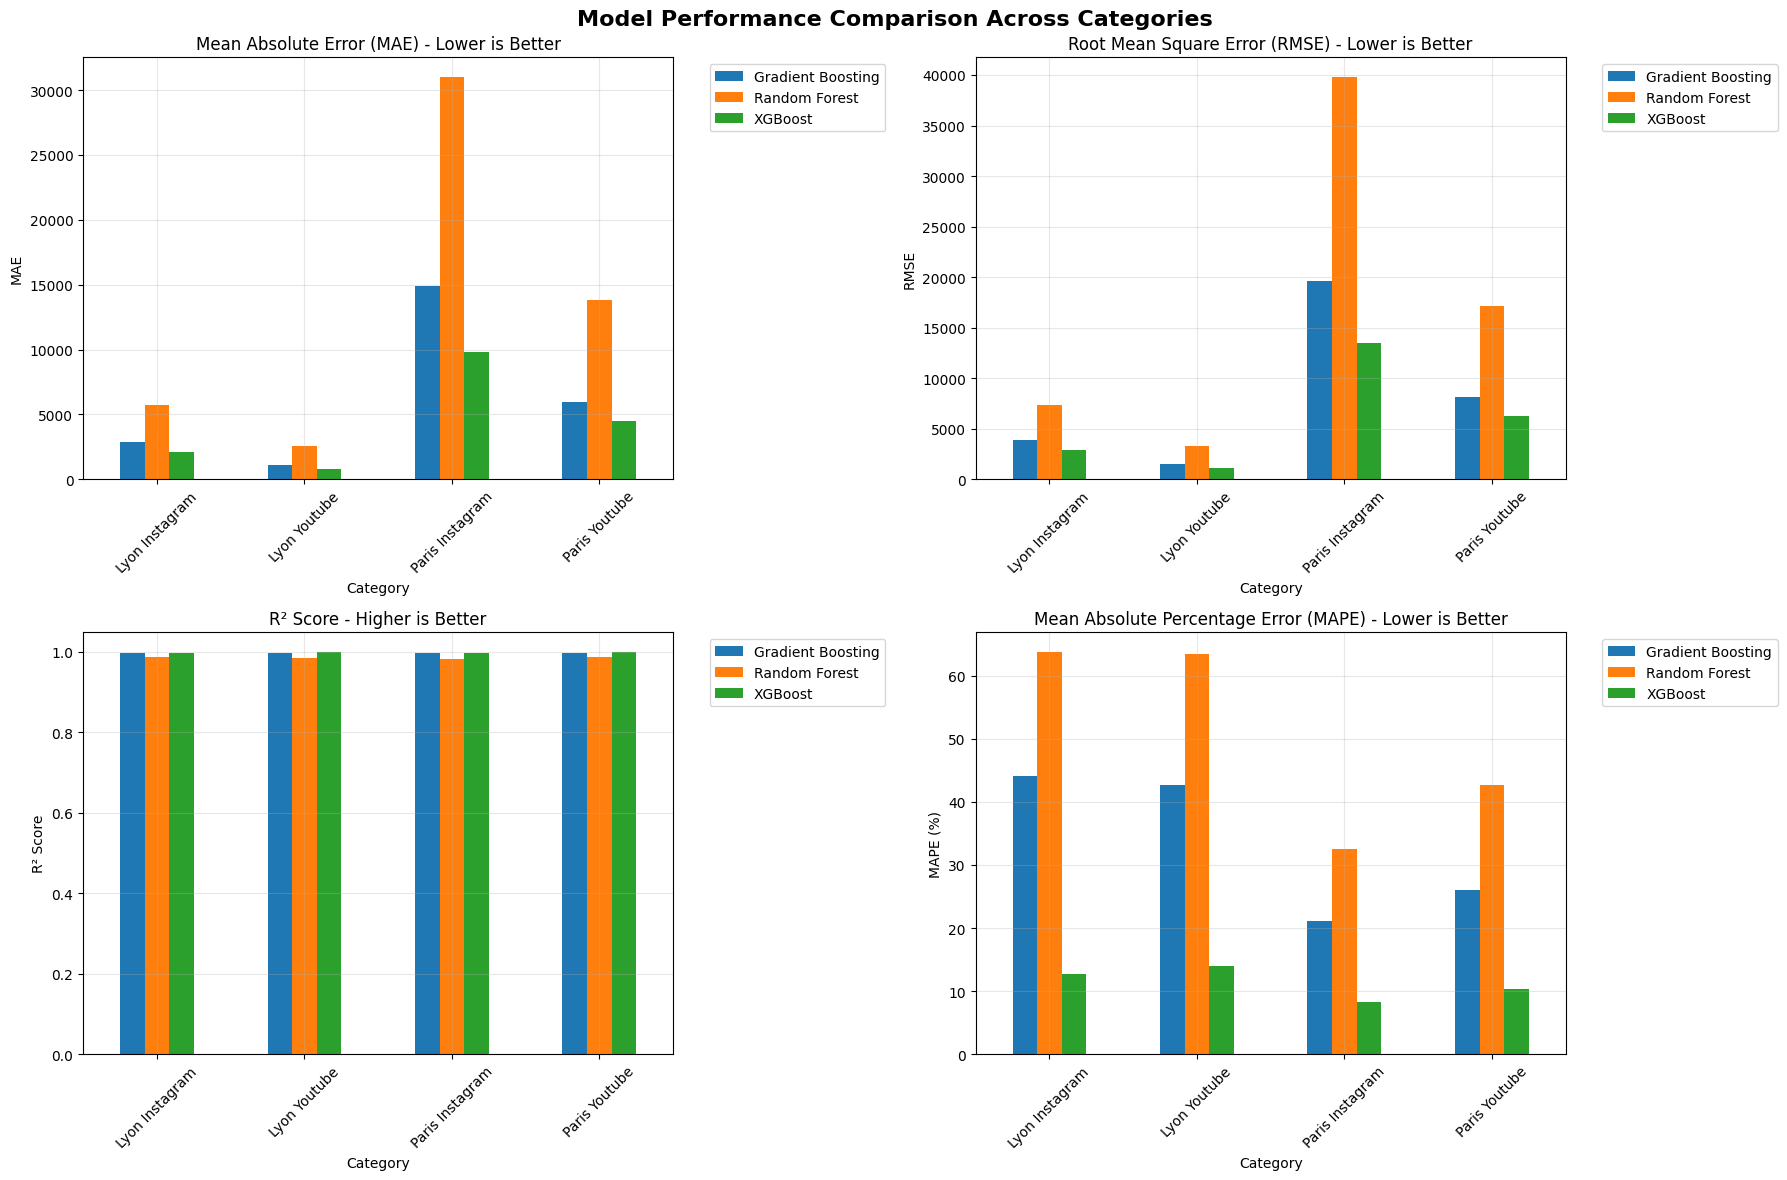

In [ ]:
# Prepare data for comparison
comparison_data = []
for category in model_results:
    models = model_results[category]
    for model_name in models:
        metrics = models[model_name]
        comparison_data.append({
            'Category': category.replace('_', ' ').title(),
            'Model': model_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R2': metrics['R2'],
            'MAPE': metrics['MAPE']
        })

comparison_df = pd.DataFrame(comparison_data)

# Create subplots for metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Model Performance Comparison Across Categories', fontsize=16, fontweight='bold')

# MAE Comparison
pivot_mae = comparison_df.pivot(index='Category', columns='Model', values='MAE')
pivot_mae.plot(kind='bar', ax=axes[0, 0], rot=45)
axes[0, 0].set_title('Mean Absolute Error (MAE) - Lower is Better')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# RMSE Comparison
pivot_rmse = comparison_df.pivot(index='Category', columns='Model', values='RMSE')
pivot_rmse.plot(kind='bar', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Root Mean Square Error (RMSE) - Lower is Better')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# R² Score Comparison
pivot_r2 = comparison_df.pivot(index='Category', columns='Model', values='R2')
pivot_r2.plot(kind='bar', ax=axes[1, 0], rot=45)
axes[1, 0].set_title('R² Score - Higher is Better')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# MAPE Comparison
pivot_mape = comparison_df.pivot(index='Category', columns='Model', values='MAPE')
pivot_mape.plot(kind='bar', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE) - Lower is Better')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Creating prediction vs actual plots...


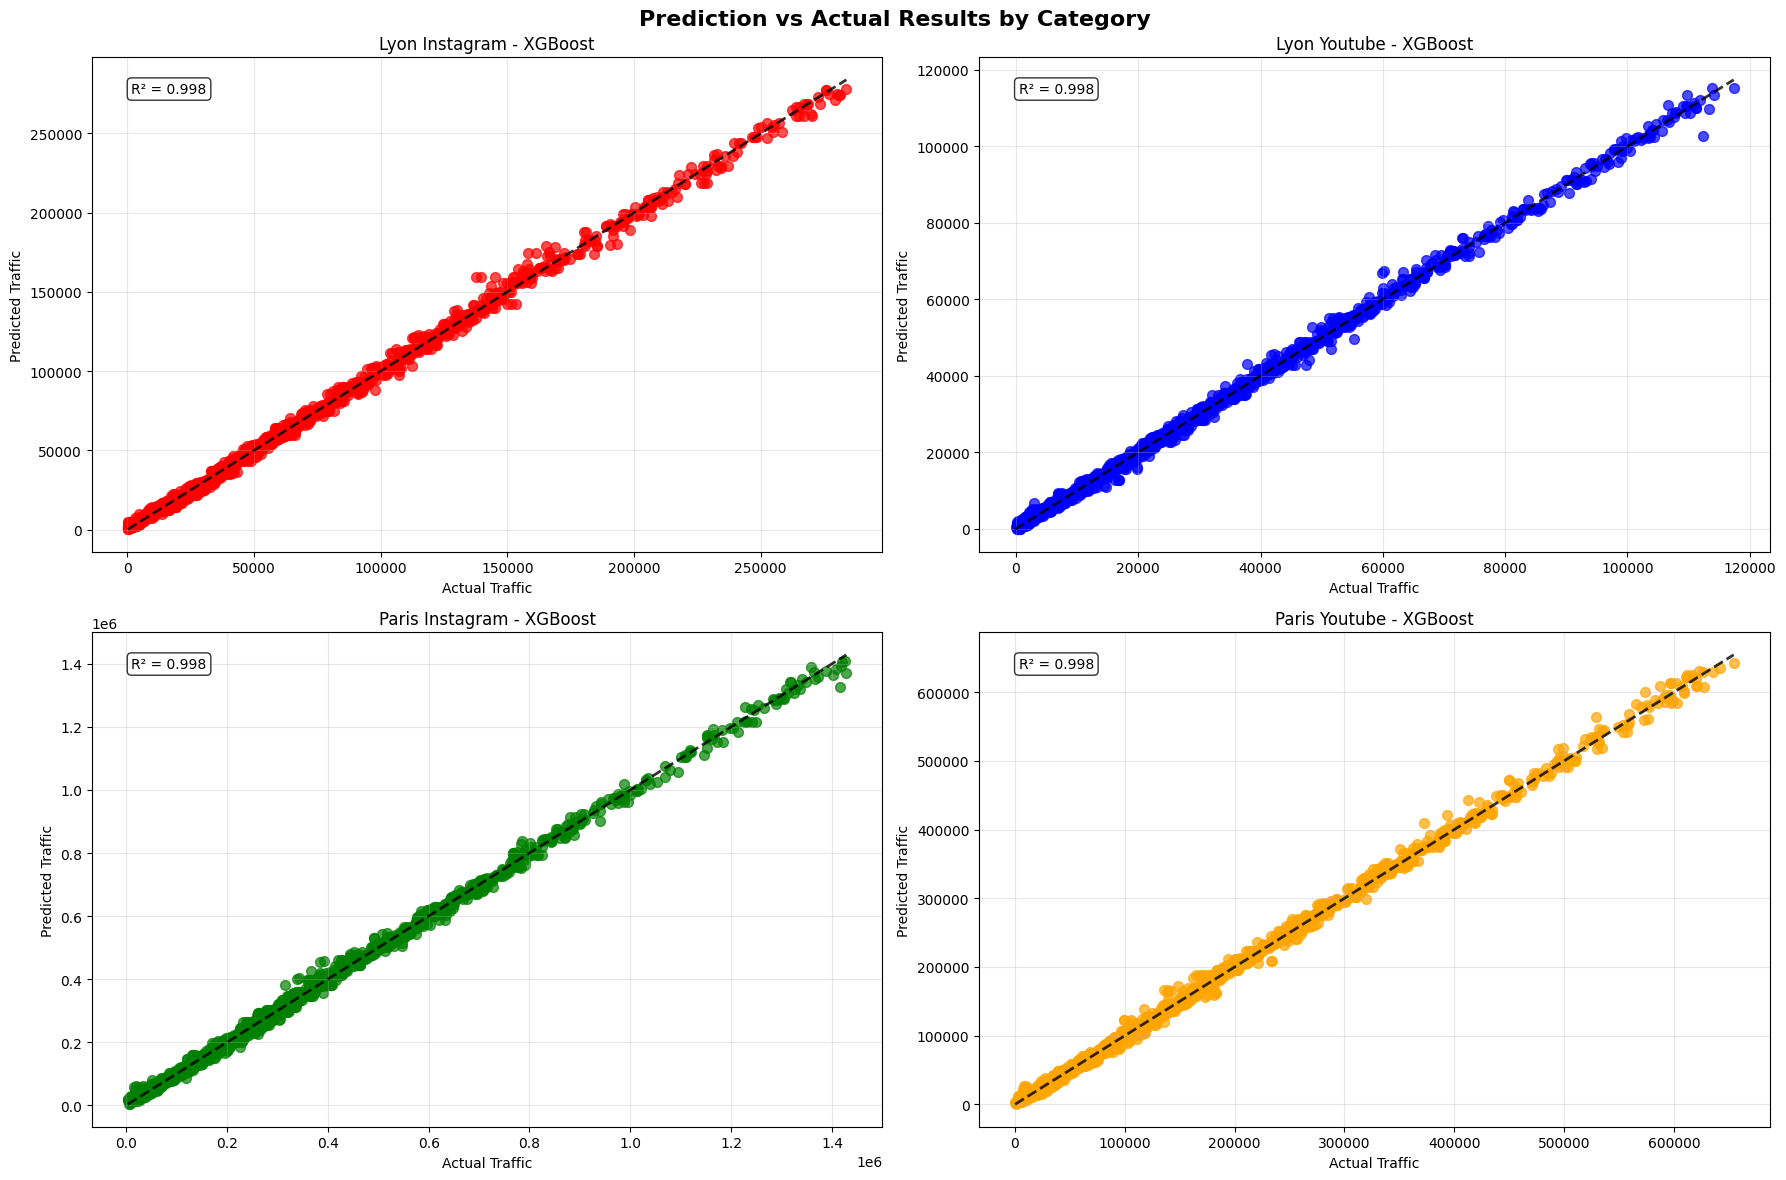

In [ ]:
# 2. PREDICTION VS ACTUAL PLOTS
print("Creating prediction vs actual plots...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Prediction vs Actual Results by Category', fontsize=16, fontweight='bold')

plot_idx = 0
colors = ['red', 'blue', 'green', 'orange']

for category in model_results:
    if plot_idx >= 4:
        break

    models = model_results[category]

    best_model = 'XGBoost'
    best_results = models[best_model]

    row = plot_idx // 2
    col = plot_idx % 2

    # Scatter plot of actual vs predicted
    axes[row, col].scatter(
        best_results['y_test'],
        best_results['y_pred'],
        alpha=0.7, color=colors[plot_idx], s=50
    )

    # Line for perfect prediction
    min_val = min(best_results['y_test'].min(), best_results['y_pred'].min())
    max_val = max(best_results['y_test'].max(), best_results['y_pred'].max())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=2)

    # Axis labels
    axes[row, col].set_xlabel('Actual Traffic')
    axes[row, col].set_ylabel('Predicted Traffic')

    # Plot title
    title_text = category.replace("_", " ").title() + " - " + best_model
    axes[row, col].set_title(title_text)

    # R² score annotation
    r2_score_value = best_results['R2']
    r2_label = 'R² = ' + str(round(r2_score_value, 3))
    axes[row, col].text(
        0.05, 0.95, r2_label,
        transform=axes[row, col].transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    axes[row, col].grid(True, alpha=0.3)
    plot_idx += 1

plt.tight_layout()
plt.show()

Creating feature importance analysis...


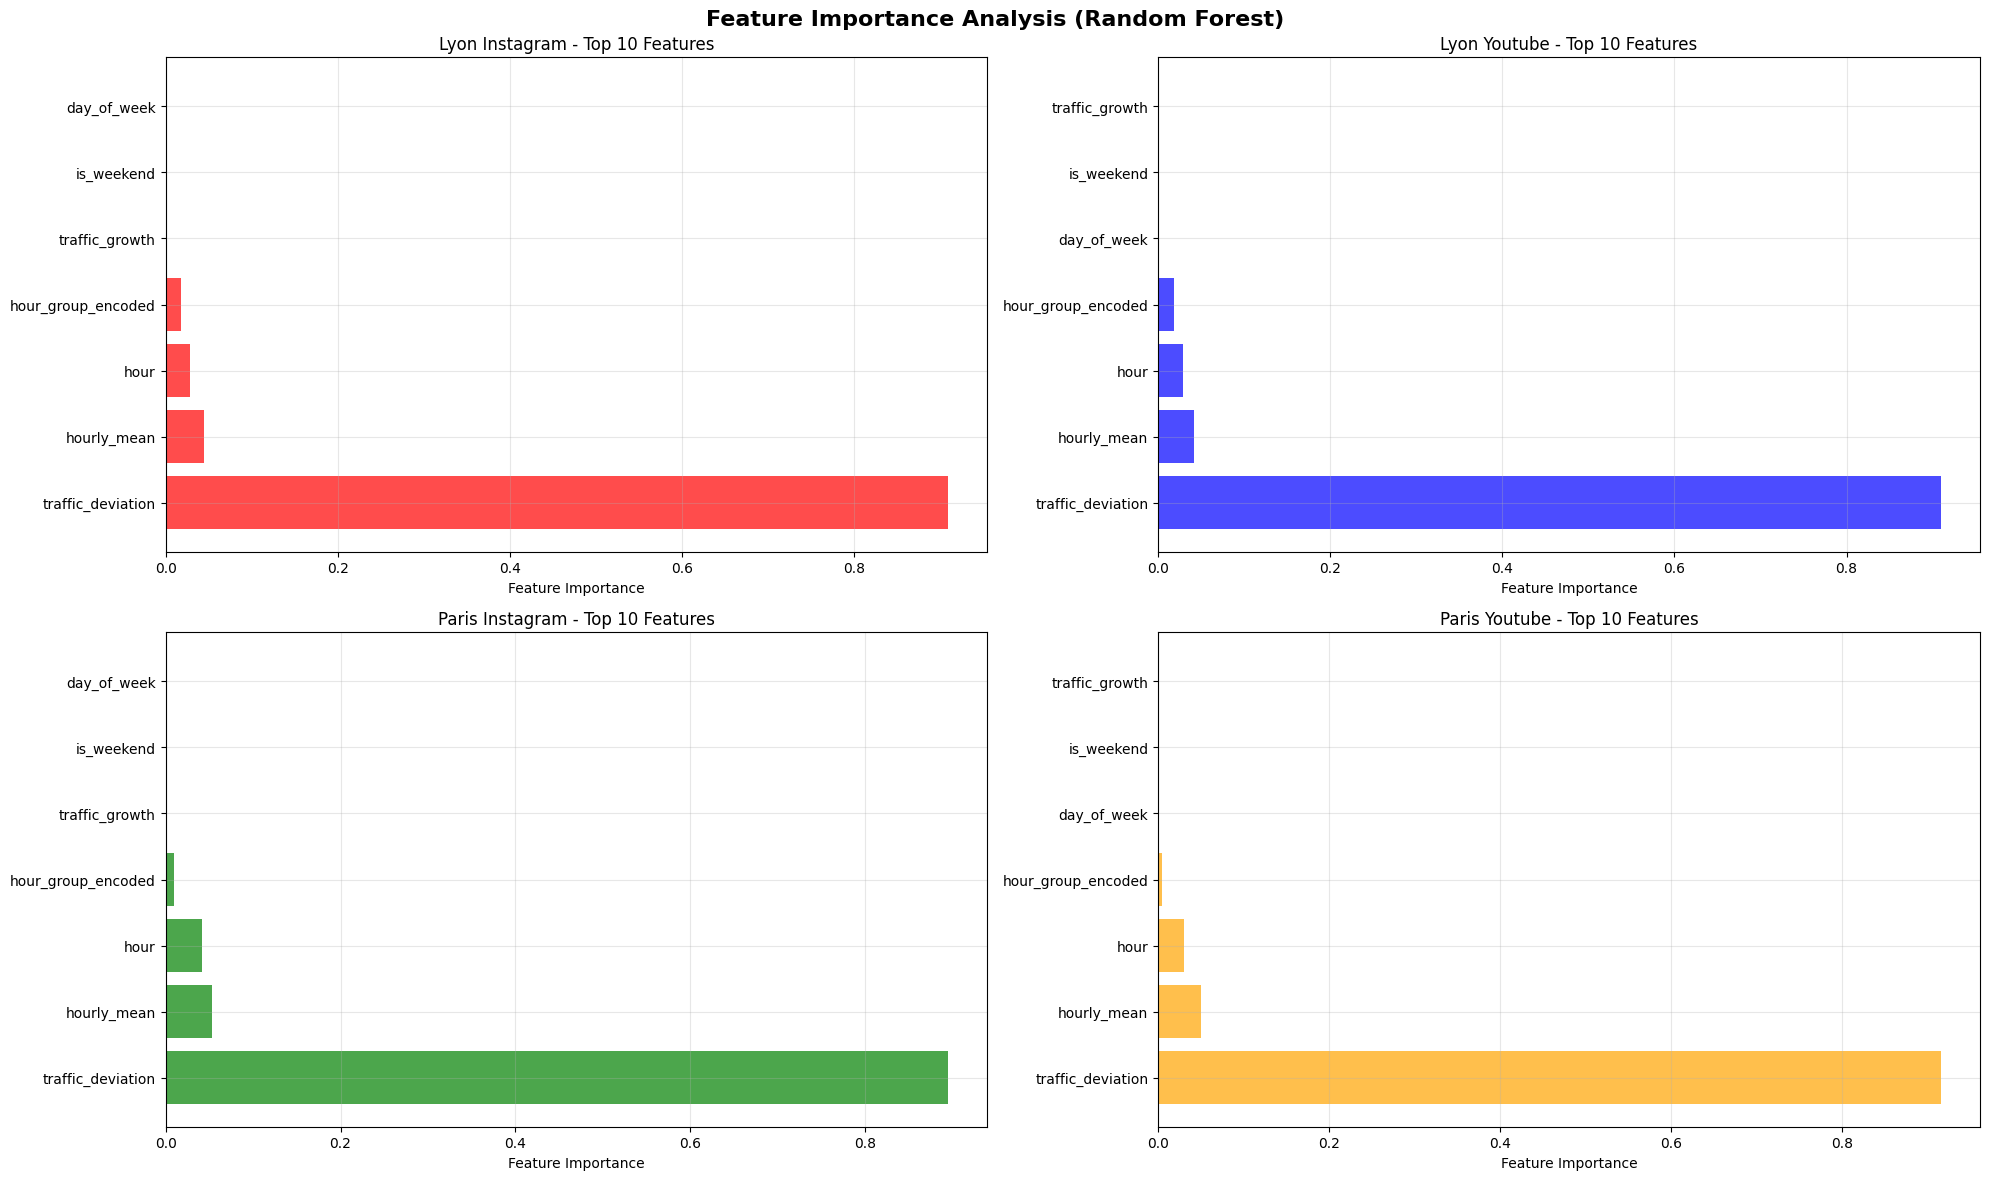


Top 10 Features for 'Paris Youtube':

           feature  percentage
 traffic_deviation       91.61
       hourly_mean        4.98
              hour        2.98
hour_group_encoded        0.42
       day_of_week        0.00
        is_weekend        0.00
    traffic_growth        0.00


<ipython-input-39-609ac5c9adc0>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importance_df['percentage'] = 100 * importance_df['importance'] / importance_df['importance'].sum()
<ipython-input-39-609ac5c9adc0>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importance_df['percentage'] = importance_df['percentage'].round(2)


In [ ]:
# 3. FEATURE IMPORTANCE ANALYSIS
print("Creating feature importance analysis...")

if feature_importance_data:
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Feature Importance Analysis (Random Forest)', fontsize=16, fontweight='bold')

    plot_idx = 0
    for category in feature_importance_data:
        models = feature_importance_data[category]

        if plot_idx >= 4:
            break

        if 'Random Forest' in models:
            row = plot_idx // 2
            col = plot_idx % 2

            importance_df = models['Random Forest'].head(10)  # Top 10 features

            axes[row, col].barh(
                range(len(importance_df)),
                importance_df['importance'],
                color=colors[plot_idx],
                alpha=0.7
            )
            axes[row, col].set_yticks(range(len(importance_df)))
            axes[row, col].set_yticklabels(importance_df['feature'])
            axes[row, col].set_xlabel('Feature Importance')

            title_text = category.replace("_", " ").title() + " - Top 10 Features"
            axes[row, col].set_title(title_text)
            axes[row, col].grid(True, alpha=0.3)

            plot_idx += 1

    plt.tight_layout()
    plt.show()

    # Normalize importances to percentages
importance_df['percentage'] = 100 * importance_df['importance'] / importance_df['importance'].sum()

# Round to 2 decimal places for display
importance_df['percentage'] = importance_df['percentage'].round(2)

# Print table
print(f"\nTop 10 Features for '{category.replace('_', ' ').title()}':\n")
print(importance_df[['feature', 'percentage']].to_string(index=False))



Creating residual analysis...


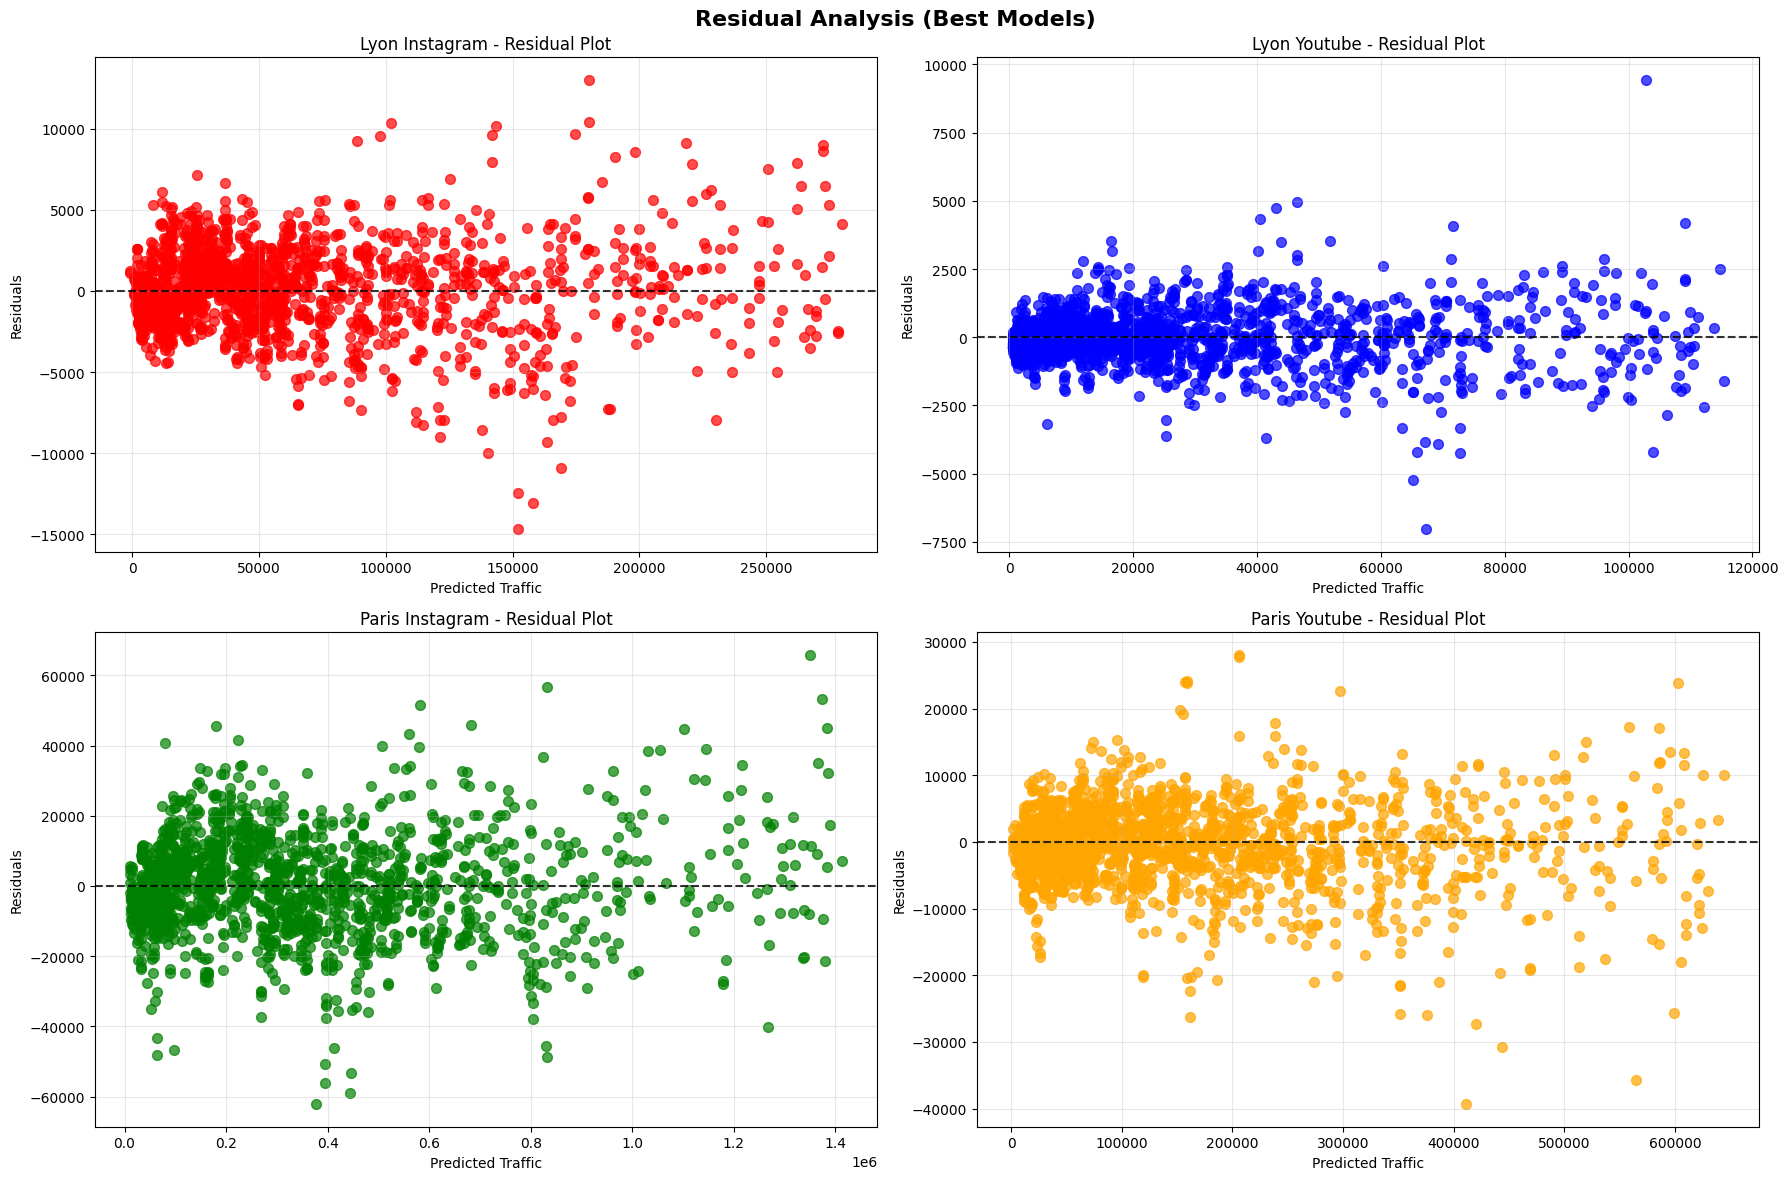

In [ ]:
# 4. RESIDUAL ANALYSIS
print("Creating residual analysis...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Residual Analysis (Best Models)', fontsize=16, fontweight='bold')

plot_idx = 0
for category in model_results:
    models = model_results[category]

    if plot_idx >= 4:
        break

    row = plot_idx // 2
    col = plot_idx % 2

    # Find best model
    best_model = max(models.keys(), key=lambda x: models[x]['R2'])
    best_results = models[best_model]

    # Calculate residuals
    residuals = best_results['y_test'] - best_results['y_pred']

    # Residual plot
    axes[row, col].scatter(best_results['y_pred'], residuals,
                           alpha=0.7, color=colors[plot_idx], s=50)
    axes[row, col].axhline(y=0, color='k', linestyle='--', alpha=0.8)
    axes[row, col].set_xlabel('Predicted Traffic')
    axes[row, col].set_ylabel('Residuals')

    title_text = category.replace("_", " ").title() + " - Residual Plot"
    axes[row, col].set_title(title_text)
    axes[row, col].grid(True, alpha=0.3)

    plot_idx += 1

plt.tight_layout()
plt.show()


In [ ]:
# 5. MODEL PERFORMANCE SUMMARY TABLE
print("\n📊 Model Performance Summary:")
print("="*100)
summary_df = comparison_df.pivot(index='Category', columns='Model', values=['MAE', 'RMSE', 'R2', 'MAPE'])
print(summary_df.round(3).to_string())


📊 Model Performance Summary:
                              MAE                                       RMSE                                         R2                                    MAPE                      
Model           Gradient Boosting Random Forest    XGBoost Gradient Boosting Random Forest    XGBoost Gradient Boosting Random Forest XGBoost Gradient Boosting Random Forest XGBoost
Category                                                                                                                                                                             
Lyon Instagram           2870.580      5724.533   2034.463          3855.632      7375.911   2707.301             0.996         0.986   0.998            44.082        63.683  14.184
Lyon Youtube             1102.531      2557.170    729.582          1482.302      3316.363   1030.449             0.997         0.984   0.998            42.679        63.392  12.515
Paris Instagram         14919.897     30971.247  10693.140  

In [ ]:
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


🔮 Step 8: Future Traffic Prediction using XGBoost
--------------------------------------------------

Creating predictions for lyon_instagram...
   Generated 24 hourly predictions
   Model R² Score: 0.998
   Predicted traffic range: 8255 - 99774

Creating predictions for lyon_youtube...
   Generated 24 hourly predictions
   Model R² Score: 0.998
   Predicted traffic range: 6225 - 41779

Creating predictions for paris_instagram...
   Generated 24 hourly predictions
   Model R² Score: 0.998
   Predicted traffic range: 78661 - 523471

Creating predictions for paris_youtube...
   Generated 24 hourly predictions
   Model R² Score: 0.998
   Predicted traffic range: 46849 - 231685

Creating prediction visualizations...


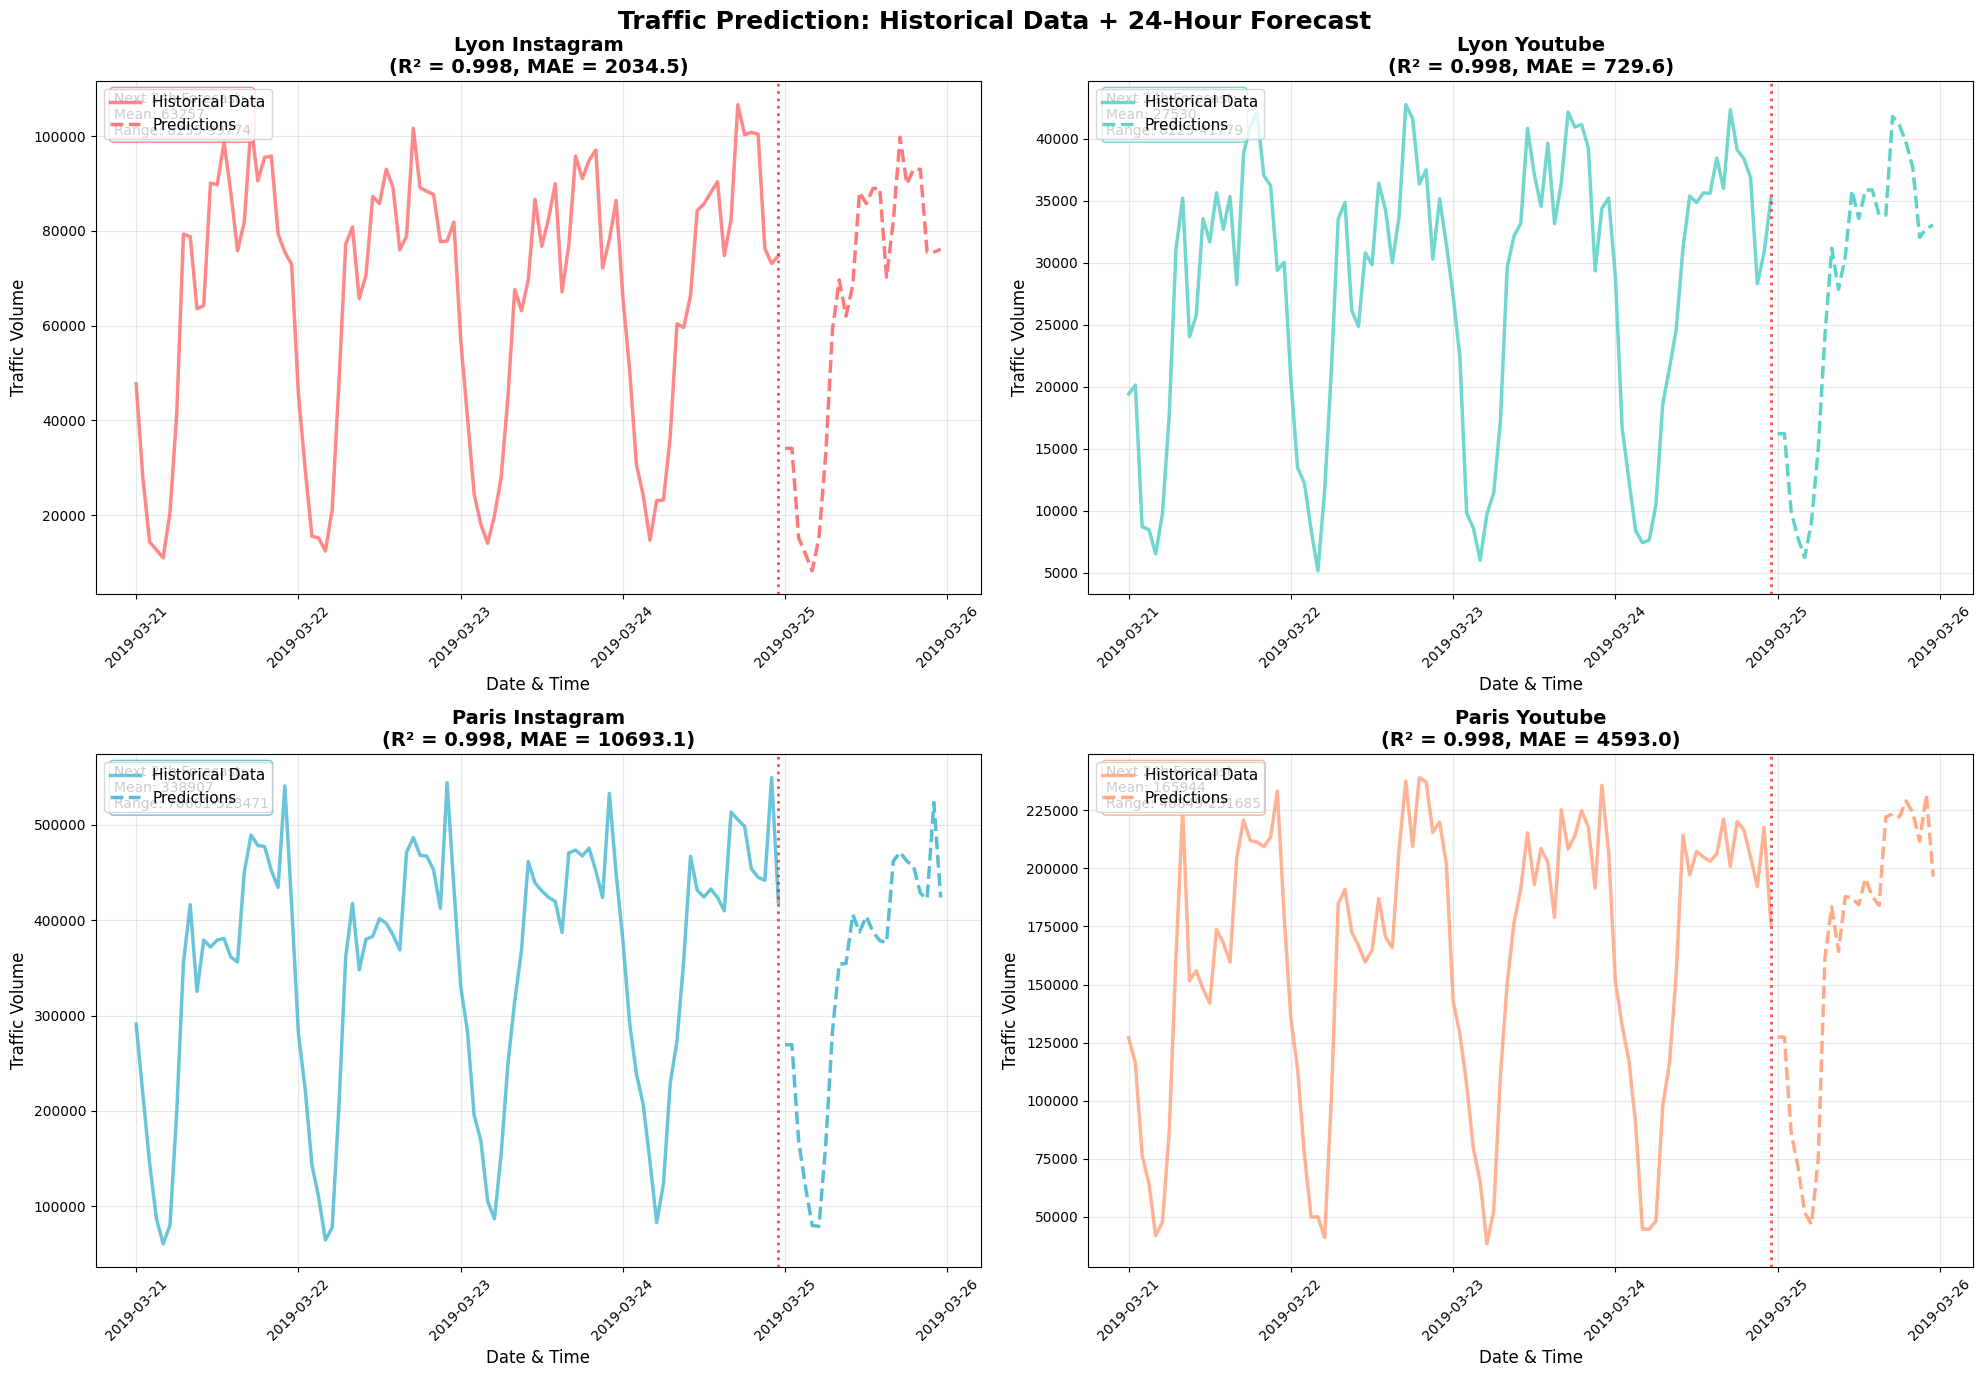

Creating combined overview visualization...


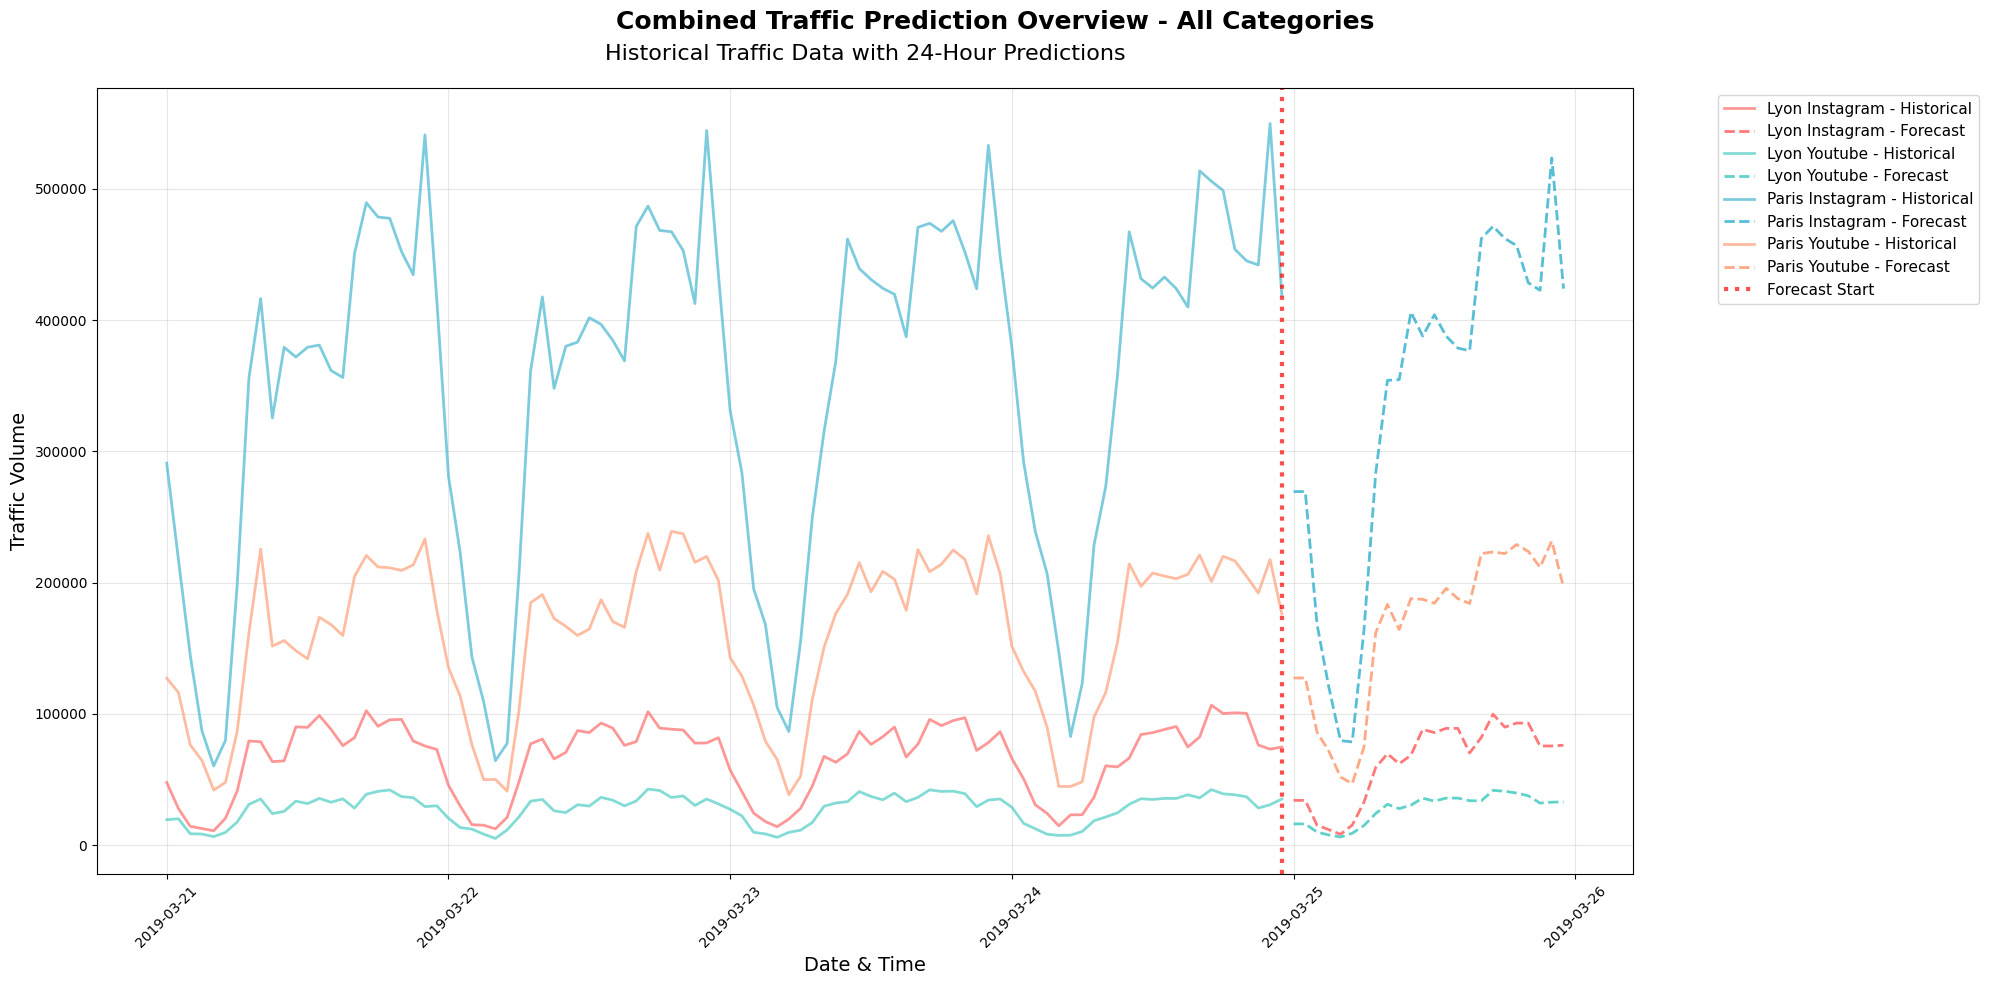

Creating hourly pattern analysis...


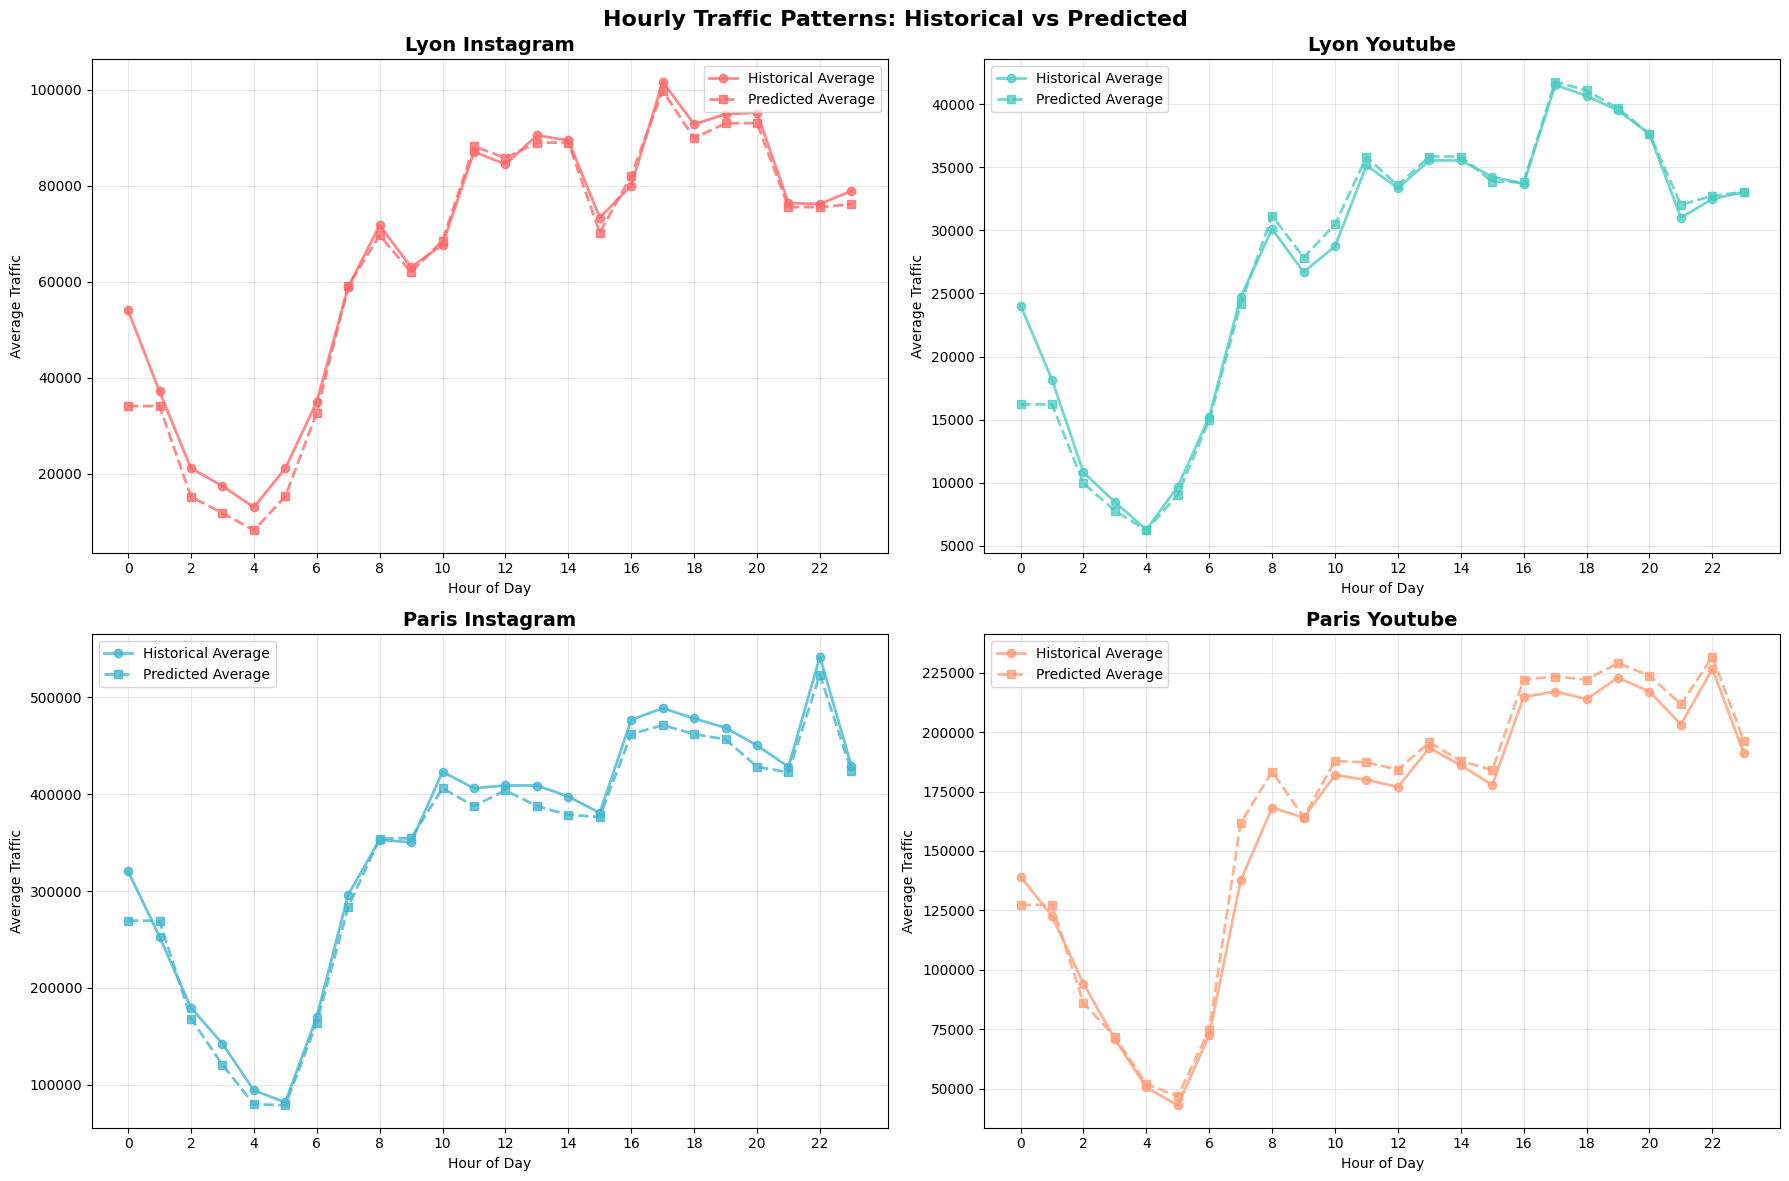


📊 PREDICTION SUMMARY

Lyon Instagram:
  • Model R² Score: 0.998
  • Model MAE: 2034.5
  • Next 24h Average: 63257
  • Predicted Peak: 99774
  • Predicted Low: 8255
  • Expected Peak Hour: 17:00

Lyon Youtube:
  • Model R² Score: 0.998
  • Model MAE: 729.6
  • Next 24h Average: 27530
  • Predicted Peak: 41779
  • Predicted Low: 6225
  • Expected Peak Hour: 17:00

Paris Instagram:
  • Model R² Score: 0.998
  • Model MAE: 10693.1
  • Next 24h Average: 338907
  • Predicted Peak: 523471
  • Predicted Low: 78661
  • Expected Peak Hour: 22:00

Paris Youtube:
  • Model R² Score: 0.998
  • Model MAE: 4593.0
  • Next 24h Average: 165944
  • Predicted Peak: 231685
  • Predicted Low: 46849
  • Expected Peak Hour: 22:00

🎯 All predictions generated using XGBoost model
📅 Forecast period: Next 24 hours
✅ Visualizations created successfully!


In [ ]:
# Replace the ARIMA section (Step 8) with this XGBoost prediction code

print("\n🔮 Step 8: Future Traffic Prediction using XGBoost")
print("-" * 50)

prediction_results = {}

# Hours to predict into the future
PREDICTION_HOURS = 24  # Predict next 24 hours

for key, df in enhanced_dataframes.items():
    print(f"\nCreating predictions for {key}...")

    best_model = model_results[key]['XGBoost']['model']

    # Sort data by datetime
    df_sorted = df.sort_values('datetime').reset_index(drop=True)

    # Get the last datetime and create future timestamps
    last_datetime = df_sorted['datetime'].max()
    future_datetimes = pd.date_range(
        start=last_datetime + pd.Timedelta(hours=1),
        periods=PREDICTION_HOURS,
        freq='H'
    )

    # Create future features
    future_data = []

    for future_dt in future_datetimes:
        # Extract time features
        hour = future_dt.hour
        day_of_week = future_dt.dayofweek
        is_weekend = 1 if day_of_week in [5, 6] else 0

        # Cyclical encoding
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        dow_sin = np.sin(2 * np.pi * day_of_week / 7)
        dow_cos = np.cos(2 * np.pi * day_of_week / 7)

        # Peak hour indicators
        is_peak_morning = 1 if 7 <= hour <= 9 else 0
        is_peak_evening = 1 if 18 <= hour <= 22 else 0
        is_late_night = 1 if hour >= 23 or hour <= 5 else 0
        is_midday = 1 if 11 <= hour <= 14 else 0

        # Hour group encoding
        if 0 <= hour <= 6:
            hour_group_encoded = 0  # Night
        elif 7 <= hour <= 12:
            hour_group_encoded = 1  # Morning
        elif 13 <= hour <= 18:
            hour_group_encoded = 2  # Afternoon
        else:
            hour_group_encoded = 3  # Evening

        # Get historical hourly statistics for this hour
        hour_traffic = df_sorted[df_sorted['hour'] == hour]['traffic']
        hourly_mean = hour_traffic.mean() if len(hour_traffic) > 0 else df_sorted['traffic'].mean()
        hourly_std = hour_traffic.std() if len(hour_traffic) > 0 else df_sorted['traffic'].std()

        # For traffic_growth, use 0 (no change) as we don't have previous values
        traffic_growth = 0

        # Traffic deviation (set to 0 for prediction)
        traffic_deviation = 0

        future_data.append({
            'hour': hour,
            'day_of_week': day_of_week,
            'is_weekend': is_weekend,
            'traffic_growth': traffic_growth,
            'hour_sin': hour_sin,
            'hour_cos': hour_cos,
            'dow_sin': dow_sin,
            'dow_cos': dow_cos,
            'is_peak_morning': is_peak_morning,
            'is_peak_evening': is_peak_evening,
            'is_late_night': is_late_night,
            'is_midday': is_midday,
            'hour_group_encoded': hour_group_encoded,
            'hourly_mean': hourly_mean,
            'traffic_deviation': traffic_deviation
        })

    # Convert to DataFrame
    future_df = pd.DataFrame(future_data)

    # Make predictions
    future_predictions = best_model.predict(future_df[feature_cols])

    # Store results
    prediction_results[key] = {
        'historical_data': df_sorted,
        'future_datetimes': future_datetimes,
        'predictions': future_predictions,
        'model_r2': model_results[key]['XGBoost']['R2'],
        'model_mae': model_results[key]['XGBoost']['MAE']
    }

    print(f"   Generated {len(future_predictions)} hourly predictions")
    print(f"   Model R² Score: {model_results[key]['XGBoost']['R2']:.3f}")
    print(f"   Predicted traffic range: {future_predictions.min():.0f} - {future_predictions.max():.0f}")

# Create comprehensive prediction visualizations
print("\nCreating prediction visualizations...")

# Create individual plots for each category
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Traffic Prediction: Historical Data + 24-Hour Forecast', fontsize=18, fontweight='bold', y=0.98)

plot_idx = 0
for key, results in prediction_results.items():
    if plot_idx >= 4:
        break

    row = plot_idx // 2
    col = plot_idx % 2
    ax = axes[row, col]

    # Prepare historical data (hourly averages)
    hist_data = results['historical_data']
    hourly_hist = hist_data.groupby(hist_data['datetime'].dt.floor('H'))['traffic'].mean().reset_index()

    # Plot historical data
    ax.plot(hourly_hist['datetime'], hourly_hist['traffic'],
            color=colors[plot_idx], linewidth=2.5, alpha=0.8, label='Historical Data')

    # Plot predictions
    future_dt = results['future_datetimes']
    predictions = results['predictions']

    ax.plot(future_dt, predictions,
            color=colors[plot_idx], linewidth=2.5, linestyle='--', alpha=0.9, label='Predictions')

    # Add a vertical line to separate historical and predicted data
    separation_line = hourly_hist['datetime'].iloc[-1]
    ax.axvline(x=separation_line, color='red', linestyle=':', alpha=0.7, linewidth=2)

    # Formatting
    title = key.replace('_', ' ').title()
    ax.set_title(f'{title}\n(R² = {results["model_r2"]:.3f}, MAE = {results["model_mae"]:.1f})',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Date & Time', fontsize=12)
    ax.set_ylabel('Traffic Volume', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11, loc='upper left')

    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

    # Add prediction statistics as text box
    pred_mean = predictions.mean()
    pred_max = predictions.max()
    pred_min = predictions.min()

    stats_text = f'Next 24h Forecast:\nMean: {pred_mean:.0f}\nRange: {pred_min:.0f}-{pred_max:.0f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3',
            facecolor='white', alpha=0.8, edgecolor=colors[plot_idx]))

    plot_idx += 1

plt.tight_layout()
plt.show()

# Create a combined overview plot
print("Creating combined overview visualization...")

plt.figure(figsize=(20, 10))
plt.suptitle('Combined Traffic Prediction Overview - All Categories', fontsize=18, fontweight='bold')

for idx, (key, results) in enumerate(prediction_results.items()):
    # Prepare historical data
    hist_data = results['historical_data']
    hourly_hist = hist_data.groupby(hist_data['datetime'].dt.floor('H'))['traffic'].mean().reset_index()

    # Plot historical data
    plt.plot(hourly_hist['datetime'], hourly_hist['traffic'],
            color=colors[idx], linewidth=2, alpha=0.7,
            label=f'{key.replace("_", " ").title()} - Historical')

    # Plot predictions
    future_dt = results['future_datetimes']
    predictions = results['predictions']

    plt.plot(future_dt, predictions,
            color=colors[idx], linewidth=2, linestyle='--', alpha=0.9,
            label=f'{key.replace("_", " ").title()} - Forecast')

# Add separation line
if prediction_results:
    first_key = list(prediction_results.keys())[0]
    separation_time = prediction_results[first_key]['historical_data']['datetime'].max()
    plt.axvline(x=separation_time, color='red', linestyle=':', alpha=0.7, linewidth=3,
               label='Forecast Start')

plt.xlabel('Date & Time', fontsize=14)
plt.ylabel('Traffic Volume', fontsize=14)
plt.title('Historical Traffic Data with 24-Hour Predictions', fontsize=16, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create hourly pattern comparison
print("Creating hourly pattern analysis...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Hourly Traffic Patterns: Historical vs Predicted', fontsize=16, fontweight='bold')

plot_idx = 0
for key, results in prediction_results.items():
    if plot_idx >= 4:
        break

    row = plot_idx // 2
    col = plot_idx % 2
    ax = axes[row, col]

    # Historical hourly pattern
    hist_data = results['historical_data']
    hist_hourly = hist_data.groupby('hour')['traffic'].mean()

    # Predicted hourly pattern
    pred_df = pd.DataFrame({
        'hour': [dt.hour for dt in results['future_datetimes']],
        'traffic': results['predictions']
    })
    pred_hourly = pred_df.groupby('hour')['traffic'].mean()

    # Plot both patterns
    ax.plot(hist_hourly.index, hist_hourly.values, 'o-',
           color=colors[plot_idx], linewidth=2, markersize=6,
           label='Historical Average', alpha=0.8)

    ax.plot(pred_hourly.index, pred_hourly.values, 's--',
           color=colors[plot_idx], linewidth=2, markersize=6,
           label='Predicted Average', alpha=0.8)

    ax.set_title(key.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Traffic')
    ax.set_xticks(range(0, 24, 2))
    ax.grid(True, alpha=0.3)
    ax.legend()

    plot_idx += 1

plt.tight_layout()
plt.show()

# Print prediction summary
print("\n📊 PREDICTION SUMMARY")
print("="*60)
for key, results in prediction_results.items():
    print(f"\n{key.replace('_', ' ').title()}:")
    print(f"  • Model R² Score: {results['model_r2']:.3f}")
    print(f"  • Model MAE: {results['model_mae']:.1f}")
    print(f"  • Next 24h Average: {results['predictions'].mean():.0f}")
    print(f"  • Predicted Peak: {results['predictions'].max():.0f}")
    print(f"  • Predicted Low: {results['predictions'].min():.0f}")

    # Find peak hour in predictions
    pred_df = pd.DataFrame({
        'hour': [dt.hour for dt in results['future_datetimes']],
        'traffic': results['predictions']
    })
    peak_hour = pred_df.groupby('hour')['traffic'].mean().idxmax()
    print(f"  • Expected Peak Hour: {peak_hour}:00")

print(f"\n All predictions generated using XGBoost model")
print(f" Forecast period: Next {PREDICTION_HOURS} hours")
print("Visualizations created successfully!")